<a href="https://colab.research.google.com/github/VVKate/Neural_University_HomeWorks/blob/main/7_%D0%9F%D0%BE%D0%BB%D0%BD%D0%BE%D1%81%D0%B2%D1%8F%D0%B7%D0%BD%D1%8B%D0%B5_%D0%B8_%D1%80%D0%B5%D0%BA%D1%83%D1%80%D1%80%D0%B5%D0%BD%D1%82%D0%BD%D1%8B%D0%B5_%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D0%BD%D0%BD%D1%8B%D0%B5_%D1%81%D0%B5%D1%82%D0%B8_%D0%B4%D0%BB%D1%8F_%D0%BF%D1%80%D0%BE%D0%B3%D0%BD%D0%BE%D0%B7%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D1%8F_%D0%B2%D1%80%D0%B5%D0%BC%D0%B5%D0%BD%D0%BD%D1%8B%D1%85_%D1%80%D1%8F%D0%B4%D0%BE%D0%B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание: Июльский курс (2020). Pro. Занятие 7
# Полносвязные и рекуррентные нейронные сети для прогнозирования временных рядов
## Верхошинская Катерина Викторовна

## **LIGHT**

### **Вариант 2**

**Задание:**

База Лукойл

1. Обучите простую полносвязную сеть для прогнозирования временного ряда (только close) и визуализируйте результат.
2. Обучите такую же архитектуру сети на прогнозирование на 10 шагов вперёд прямым способом и визуализируйте результат.
3. Постройте графики сравнения предсказания с оригинальным сигналом по всем 10 шагам предсказания (10 графиков на разных отдельных осях).
4. Сделайте те же задания с другой сетью, которая будет использовать Conv1D или LSTM слои.


In [ ]:
#Загружаем библиотеки

import pandas as pd #Пандас
import matplotlib.pyplot as plt #Отрисовка графиков
from tensorflow.keras import utils #Для to_categorical
import numpy as np #Numpy
from tensorflow.keras.optimizers import Adam #Оптимизатор
from tensorflow.keras.models import Sequential, Model #Два варианты моделей
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM, GlobalMaxPooling1D #Стандартные слои
from sklearn.preprocessing import StandardScaler, MinMaxScaler #Нормировщики
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator # для генерации выборки временных рядов

# Рисовать графики сразу же
%matplotlib inline

In [ ]:
#Считываем данные с помощью pandas
base_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Базы/Акции Лукойл/18_19.csv', sep=';')

In [ ]:
#Выводим пять первых строк
base_data.head()

,DATE,TIME,OPEN,MAX,MIN,CLOSE,VOLUME
0,03.01.2018,10:00:00,3341.0,3356.0,3340.0,3355.0,6088
1,03.01.2018,10:01:00,3355.0,3359.0,3353.0,3353.0,1624
2,03.01.2018,10:02:00,3351.5,3357.5,3351.5,3357.5,722
3,03.01.2018,10:03:00,3354.5,3360.0,3354.5,3358.0,3034
4,03.01.2018,10:04:00,3358.0,3360.0,3351.5,3360.0,1427


In [ ]:
#Выцепялем numpy значения .values
#И выводим нулевой
txt = base_data.values[0]
print(txt)

['03.01.2018' '10:00:00' 3341.0 3356.0 3340.0 3355.0 6088]


In [ ]:
base_data18 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Базы/Акции Лукойл/18_19.csv', sep=';')
data18_19 = base_data18.iloc[:,2:]

In [ ]:
# Выводим параметры одного файла
d = data18_19
print(len(d)) # Сколько есть записей
print(len(d.iloc[0])) # Длина одной строки данных
print(d.iloc[0]) # Пример первой строки данных

217947
5
OPEN      3341.0
MAX       3356.0
MIN       3340.0
CLOSE     3355.0
VOLUME    6088.0
Name: 0, dtype: float64


In [ ]:
data = data18_19.copy()  # Создаем копию базы
data = np.array(data)    # Превращаем в numpy массив
print(len(data)) # Выводим размер базы

217947


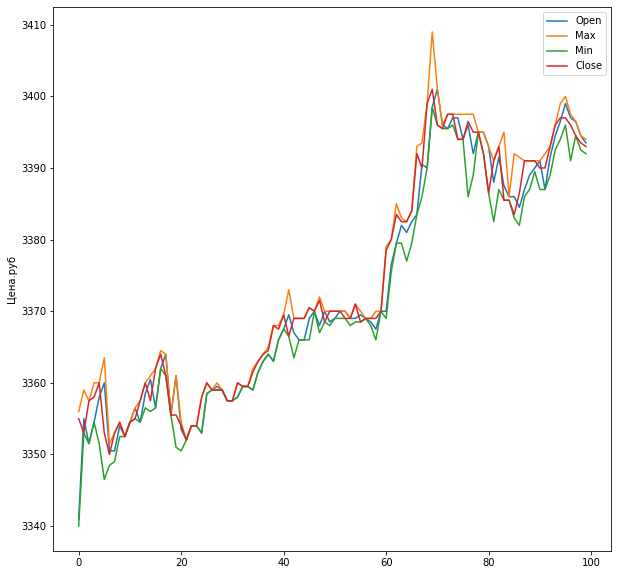

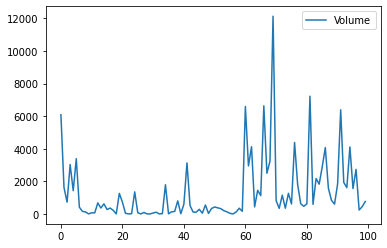

In [ ]:
plt.figure(figsize=(10,10))
#Отображаем исходные от точки start и длинной stop
start = 0            #С какой точки начинаем
#stop = data.shape[0] #Сколько точек отрисуем
stop = 100 #Сколько точек отрисуем

#Заполняем текстовые названия каналов данных
chanelNames = ['Open', 'Max', 'Min', 'Close', 'Volume']

#Рисуем все графики данных
#ЧЕтыре основных канала - open, max, min, close
for i in range(4):
  #Отрисовываем часть данных
  #От начальной точки, до начальной точки + размер шага отрисовки
  plt.plot(data[start:start+stop,i], 
          label=chanelNames[i])
plt.ylabel('Цена.руб')
plt.legend()
plt.show()

#Канал volume
plt.plot(data[start:start+stop,4], label="Volume")
plt.legend()
plt.show()

In [ ]:
#Формируем параметры загрузки данных

xLen = 300                      #Анализируем по 300 прошедшим точкам 
valLen = 30000                  #Используем 30.000 записей для проверки

trainLen = data.shape[0]-valLen # Размер тренировочной выборки

#Делим данные на тренировочную и тестовую выборки 
xTrain,xTest = data[:trainLen], data[trainLen+xLen+2:]

#Масштабируем данные (отдельно для X и Y), чтобы их легче было скормить сетке
xScaler = MinMaxScaler()
xScaler.fit(xTrain)
xTrain = xScaler.transform(xTrain)
xTest = xScaler.transform(xTest)

#Делаем reshape,т.к. у нас только один столбец по одному значению
yTrain,yTest = np.reshape(data[:trainLen,3],(-1,1)), np.reshape(data[trainLen+xLen+2:,3],(-1,1)) 
yScaler = MinMaxScaler()
yScaler.fit(yTrain)
yTrain = yScaler.transform(yTrain)
yTest = yScaler.transform(yTest)

#Создаем генератор для обучения
trainDataGen = TimeseriesGenerator(xTrain, yTrain,           #В качестве параметров наши выборки
                               length=xLen, stride=1, sampling_rate=1, #Для каждой точки (из промежутка длины xLen)
                               batch_size=200)                #Размер batch, который будем скармливать модели

#Создаем аналогичный генератор для валидации при обучении
testDataGen = TimeseriesGenerator(xTest, yTest,
                               length=xLen, stride=1,
                               batch_size=200)

In [ ]:
yTrain[0]

array([0.00188964])

In [ ]:
xTrain[0]

array([0.        , 0.00170164, 0.        , 0.00188964, 0.00141702])

In [ ]:
print(trainDataGen[0][0].shape,
      trainDataGen[0][1].shape)

(200, 300, 5) (200, 1)


#### Полносвязная сеть




Epoch 1/50
939/939 [==============================] - 4s 4ms/step - loss: 0.0154 - val_loss: 0.0443
Epoch 2/50
939/939 [==============================] - 4s 4ms/step - loss: 0.0013 - val_loss: 2.3658e-04
Epoch 3/50
939/939 [==============================] - 4s 4ms/step - loss: 0.0266 - val_loss: 6.6136e-05
Epoch 4/50
939/939 [==============================] - 4s 4ms/step - loss: 1.1215e-04 - val_loss: 1.2868e-04
Epoch 5/50
939/939 [==============================] - 4s 4ms/step - loss: 3.5655e-04 - val_loss: 3.9907e-04
Epoch 6/50
939/939 [==============================] - 4s 4ms/step - loss: 0.0430 - val_loss: 7.3461e-05
Epoch 7/50
939/939 [==============================] - 4s 4ms/step - loss: 4.9505e-05 - val_loss: 5.7676e-05
Epoch 8/50
939/939 [==============================] - 4s 4ms/step - loss: 5.9530e-05 - val_loss: 2.3146e-04
Epoch 9/50
939/939 [==============================] - 4s 4ms/step - loss: 1.1060e-04 - val_loss: 3.5010e-05
Epoch 10/50
939/939 [===========================

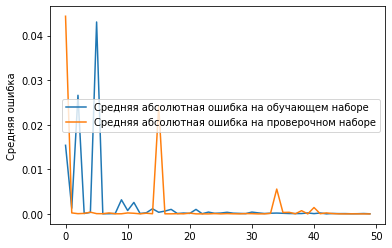

In [ ]:
#Создаём модель
modelD = Sequential()

modelD.add(Dense(200 ,input_shape = (xLen,5), activation="linear" )) # 5 - количество каналов
modelD.add(Flatten())
modelD.add(Dense(1, activation="linear"))

#Компилируем
modelD.compile(loss="mse", optimizer=Adam(lr=1e-4))

#Запускаем обучение
history = modelD.fit_generator(
                    trainDataGen, 
                    epochs=50, 
                    verbose=1, 
                    validation_data = testDataGen 
                    )

#Выводим графики
plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [ ]:
modelD.compile(loss="mse", optimizer=Adam(lr=1e-5))
history = modelD.fit_generator(
                    trainDataGen, 
                    epochs=50, 
                    verbose=1, 
                    validation_data = testDataGen 
                    )

Epoch 1/50
939/939 [==============================] - 4s 5ms/step - loss: 1.1706e-05 - val_loss: 1.3213e-05
Epoch 2/50
939/939 [==============================] - 4s 5ms/step - loss: 1.0538e-05 - val_loss: 9.7832e-06
Epoch 3/50
939/939 [==============================] - 4s 5ms/step - loss: 1.0855e-05 - val_loss: 1.1239e-05
Epoch 4/50
939/939 [==============================] - 4s 4ms/step - loss: 1.0110e-05 - val_loss: 9.6866e-06
Epoch 5/50
939/939 [==============================] - 4s 5ms/step - loss: 9.9661e-06 - val_loss: 9.0194e-06
Epoch 6/50
939/939 [==============================] - 4s 4ms/step - loss: 8.8757e-06 - val_loss: 8.5202e-06
Epoch 7/50
939/939 [==============================] - 4s 5ms/step - loss: 1.0469e-05 - val_loss: 1.2204e-05
Epoch 8/50
939/939 [==============================] - 4s 5ms/step - loss: 8.5211e-06 - val_loss: 7.9752e-06
Epoch 9/50
939/939 [==============================] - 4s 5ms/step - loss: 8.1707e-06 - val_loss: 7.6713e-06
Epoch 10/50
939/939 [=======

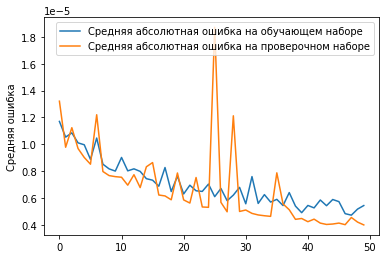

In [ ]:
#Выводим графики
plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

##### Визуализация результатов


In [ ]:
# Функция рассчитываем результаты прогнозирования сети
# В аргументы принимает сеть (currModel) и проверочную выборку
# Выдаёт результаты предсказания predVal
# И правильные ответы в исходной размерности yValUnscaled (какими они были до нормирования)
def getPred(currModel, xVal, yVal, yScaler):
  # Предсказываем ответ сети по проверочной выборке
  # И возвращаем исходны масштаб данных, до нормализации
  predVal = yScaler.inverse_transform(currModel.predict(xVal))
  yValUnscaled = yScaler.inverse_transform(yVal)
  
  return (predVal, yValUnscaled)

# Функция визуализирует графики, что предсказала сеть и какие были правильные ответы
# start - точка с которой начинаем отрисовку графика
# step - длина графика, которую отрисовываем
# channel - какой канал отрисовываем
def showPredict(start, step, channel, predVal, yValUnscaled):
  plt.plot(predVal[start:start+step, 0],
           label='Прогноз')
  plt.plot(yValUnscaled[start:start+step, channel], 
           label='Базовый ряд')
  plt.xlabel('Время')
  plt.ylabel('Значение Close')
  plt.legend()
  plt.show()
  
# Функция расёта корреляции дух одномерных векторов
def correlate(a, b):
  # Рассчитываем основные показатели
  ma = a.mean() # Среднее значение первого вектора
  mb = b.mean() # Среднее значение второго вектора
  mab = (a*b).mean() # Среднее значение произведения векторов
  sa = a.std() # Среднеквадратичное отклонение первого вектора
  sb = b.std() # Среднеквадратичное отклонение второго вектора
  
  #Рассчитываем корреляцию
  val = 1
  if ((sa>0) & (sb>0)):
    val = (mab-ma*mb)/(sa*sb)
  return val

# Функция рисуем корреляцию прогнозированного сигнала с правильным
# Смещая на различное количество шагов назад
# Для проверки появления эффекта автокорреляции
# channels - по каким каналам отображать корреляцию
# corrSteps - на какое количество шагов смещать сигнал назад для рассчёта корреляции
def showCorr(channels, corrSteps, predVal, yValUnscaled):
  # Проходим по всем каналам
  for ch in channels:
    corr = [] # Создаём пустой лист, в нём будут корреляции при смезении на i рагов обратно
    yLen = yValUnscaled.shape[0] # Запоминаем размер проверочной выборки

      # Постепенно увеличикаем шаг, насколько смещаем сигнал для проверки автокорреляции
    for i in range(corrSteps):
      # Получаем сигнал, смещённый на i шагов назад
      # predVal[i:, ch]
      # Сравниваем его с верными ответами, без смещения назад
      # yValUnscaled[:yLen-i,ch]
      # Рассчитываем их корреляцию и добавляем в лист
      corr.append(correlate(yValUnscaled[:yLen-i,ch], predVal[i:, 0]))

    own_corr = [] # Создаём пустой лист, в нём будут корреляции при смезении на i рагов обратно

      # Постепенно увеличикаем шаг, насколько смещаем сигнал для проверки автокорреляции
    for i in range(corrSteps):
      # Получаем сигнал, смещённый на i шагов назад
      # predVal[i:, ch]
      # Сравниваем его с верными ответами, без смещения назад
      # yValUnscaled[:yLen-i,ch]
      # Рассчитываем их корреляцию и добавляем в лист
      own_corr.append(correlate(yValUnscaled[:yLen-i,ch], yValUnscaled[i:, ch]))

    # Отображаем график коррелций для данного шага
    plt.plot(corr, label='Предсказание на ' + str(ch+1) + ' шаг')
    plt.plot(own_corr, label='Эталон')

  plt.xlabel('Время')
  plt.ylabel('Значение')
  plt.legend()
  plt.show()

In [ ]:
#Создадим генератор проверочной выборки, из которой потом вытащим xVal, yVal для проверки
DataGen = TimeseriesGenerator(xTest, yTest,
                               length=300, sampling_rate=1,
                               batch_size=len(xTest)) #размер batch будет равен длине нашей выборки
xVal = []
yVal = []
for i in DataGen:
  xVal.append(i[0])
  yVal.append(i[1])

xVal = np.array(xVal)
yVal = np.array(yVal)

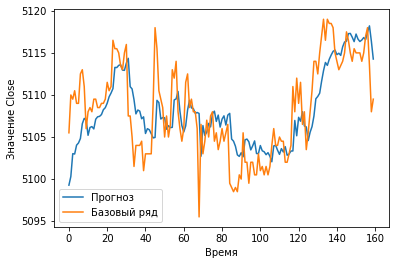

In [ ]:
#Прогнозируем данные текущей сетью
currModel = modelD #Выбираем текущую модель
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], yScaler) #Прогнозируем данные

#Отображаем графики
showPredict(0, 160, 0, predVal, yValUnscaled)


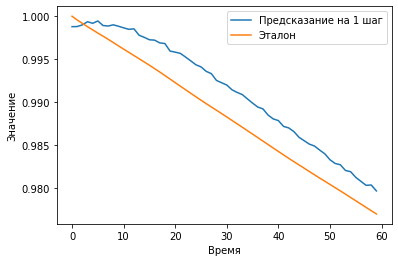

In [ ]:
#Отображаем корреляцию
#Используем выходной канал - только open
#Проверяем корреляцию на глубину 60 шагов
showCorr([0], 60, predVal, yValUnscaled)

##### Прогнозирование на 10 шагов вперёд

In [ ]:
#Формируем параметры загрузки данных
xLen = 20                       #Анализируем по 20 прошедшим точкам 
valLen = 100                    #Используем 100 записей для проверки
stepsForward = 10
trainLen = data.shape[0]-valLen #Размер тренировочной выборки

#Делим данные на тренировочную и тестовую выборки 
xTrain,xTest = data[:trainLen-stepsForward], data[trainLen+xLen+2:-stepsForward+1]

#Масштабируем данные (отдельно для X и Y), чтобы их легче было скормить сетке
xScaler = StandardScaler()
xScaler.fit(xTrain)
xTrain = xScaler.transform(xTrain)
xTest = xScaler.transform(xTest)

#Для подготовки yTrain на 10 шагов вперед необходимо создать дополнительный датасет
yTrain = np.array([data[:trainLen,0][i:i+stepsForward] for i in range(trainLen-stepsForward)])
yTest = np.array([data[trainLen+xLen+2:,0][i:i+stepsForward] for i in range(valLen-xLen-stepsForward-1)])
yScaler = StandardScaler()
yScaler.fit(yTrain)
yTrain = yScaler.transform(yTrain)
yTest = yScaler.transform(yTest)

#Создаем генератор для обучения
trainDataGen = TimeseriesGenerator(xTrain, yTrain,           #В качестве параметров наши выборки
                               length=xLen, sampling_rate=1, #Для каждой точки
                               batch_size=20)                #Размер batch, который будем скармливать модели

#Создаем аналогичный генератор для валидации при обучении
testDataGen = TimeseriesGenerator(xTest, yTest,
                               length=xLen, sampling_rate=1,
                               batch_size=20)

In [ ]:
print(trainDataGen[10][0].shape,
      trainDataGen[10][1].shape)

(20, 20, 5) (20, 10)


In [ ]:
#Создадим генератор проверочной выборки, из которой потом вытащим xVal, yVal для проверки
DataGen = TimeseriesGenerator(xTest, yTest,
                               length=xLen, sampling_rate=1,
                               batch_size=len(xTest)) #Размер batch будет равен длине нашей выборки

xVal = []
yVal = []
for i in DataGen:
  xVal.append(i[0])
  yVal.append(i[1])

xVal = np.array(xVal)
yVal = np.array(yVal)

**Обучаем полносвязную сеть**

Epoch 1/100
10891/10891 [==============================] - 29s 3ms/step - loss: 0.0030 - val_loss: 5.0857e-04
Epoch 2/100
10891/10891 [==============================] - 29s 3ms/step - loss: 8.7279e-04 - val_loss: 6.0093e-04
Epoch 3/100
10891/10891 [==============================] - 29s 3ms/step - loss: 0.0010 - val_loss: 8.7876e-04
Epoch 4/100
10891/10891 [==============================] - 29s 3ms/step - loss: 5.3711e-04 - val_loss: 5.3187e-04
Epoch 5/100
10891/10891 [==============================] - 29s 3ms/step - loss: 9.8772e-04 - val_loss: 7.7520e-04
Epoch 6/100
10891/10891 [==============================] - 29s 3ms/step - loss: 0.0011 - val_loss: 9.9001e-04
Epoch 7/100
10891/10891 [==============================] - 29s 3ms/step - loss: 6.7833e-04 - val_loss: 2.3992e-04
Epoch 8/100
10891/10891 [==============================] - 29s 3ms/step - loss: 5.4062e-04 - val_loss: 6.1126e-04
Epoch 9/100
10891/10891 [==============================] - 29s 3ms/step - loss: 5.3427e-04 - val_los

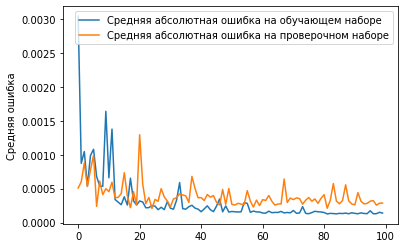

In [ ]:
# Создаем модель
modelD2 = Sequential()

modelD2.add(Dense(100, input_shape = (xLen,xTrain.shape[1]), activation="linear"))
modelD2.add(Dense(100, activation="linear"))
modelD2.add(Dense(100, activation="linear"))
modelD2.add(Flatten())
modelD2.add(Dense(yTrain.shape[1], activation="linear"))

# Компилируем
modelD2.compile(loss="mse", optimizer=Adam(lr=1e-4))

# Обучаем
history = modelD2.fit_generator(
                    trainDataGen, 
                    epochs=100, 
                    verbose=1, 
                    validation_data = testDataGen 
                    )

# Визуализируем результаты
plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [ ]:
# Дообучаем
modelD2.compile(loss="mse", optimizer=Adam(lr=1e-5))
history = modelD2.fit_generator(
                    trainDataGen, 
                    epochs=20, 
                    verbose=1, 
                    validation_data = testDataGen 
                    )

Epoch 1/20
10891/10891 [==============================] - 28s 3ms/step - loss: 1.0086e-04 - val_loss: 3.1149e-04
Epoch 2/20
10891/10891 [==============================] - 29s 3ms/step - loss: 9.9798e-05 - val_loss: 3.2233e-04
Epoch 3/20
10891/10891 [==============================] - 28s 3ms/step - loss: 9.9561e-05 - val_loss: 3.1643e-04
Epoch 4/20
10891/10891 [==============================] - 28s 3ms/step - loss: 9.9582e-05 - val_loss: 3.0602e-04
Epoch 5/20
10891/10891 [==============================] - 28s 3ms/step - loss: 9.9659e-05 - val_loss: 2.9446e-04
Epoch 6/20
10891/10891 [==============================] - 28s 3ms/step - loss: 9.9208e-05 - val_loss: 3.1970e-04
Epoch 7/20
10891/10891 [==============================] - 29s 3ms/step - loss: 9.9532e-05 - val_loss: 3.1512e-04
Epoch 8/20
10891/10891 [==============================] - 28s 3ms/step - loss: 9.9285e-05 - val_loss: 2.8578e-04
Epoch 9/20
10891/10891 [==============================] - 28s 3ms/step - loss: 9.9576e-05 - val_

##### **Отображаем результаты** (10 графиков на разных отдельных осях)

In [ ]:
# Прогнозируем данные текущей сетью
currModel = modelD2
(predVal2, yValUnscaled2) = getPred(currModel, xVal[0], yVal[0], yScaler)

***************************************************
Прогнозирование на 1 шаг(а/ов) вперед:


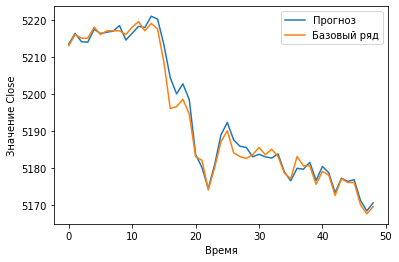

***************************************************
***************************************************
Прогнозирование на 2 шаг(а/ов) вперед:


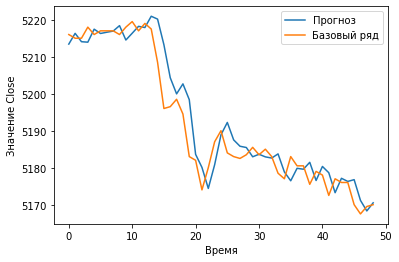

***************************************************
***************************************************
Прогнозирование на 3 шаг(а/ов) вперед:


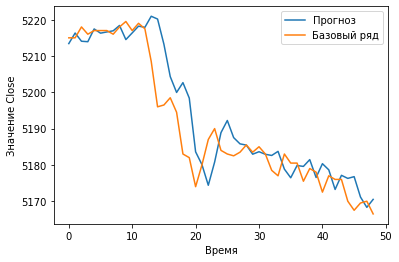

***************************************************
***************************************************
Прогнозирование на 4 шаг(а/ов) вперед:


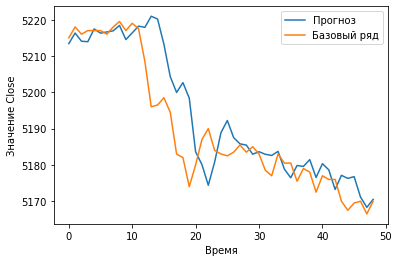

***************************************************
***************************************************
Прогнозирование на 5 шаг(а/ов) вперед:


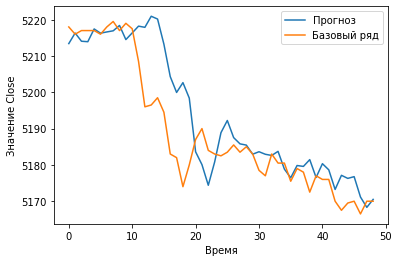

***************************************************
***************************************************
Прогнозирование на 6 шаг(а/ов) вперед:


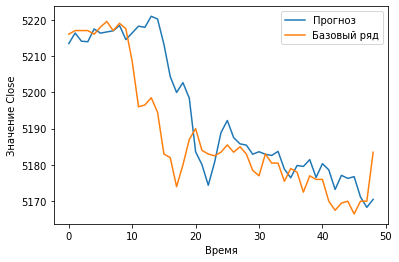

***************************************************
***************************************************
Прогнозирование на 7 шаг(а/ов) вперед:


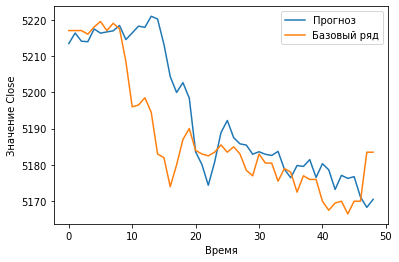

***************************************************
***************************************************
Прогнозирование на 8 шаг(а/ов) вперед:


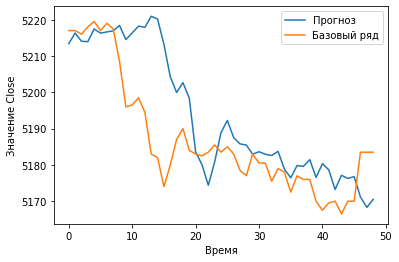

***************************************************
***************************************************
Прогнозирование на 9 шаг(а/ов) вперед:


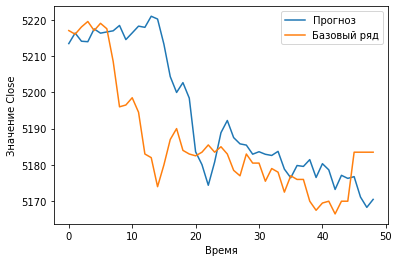

***************************************************
***************************************************
Прогнозирование на 10 шаг(а/ов) вперед:


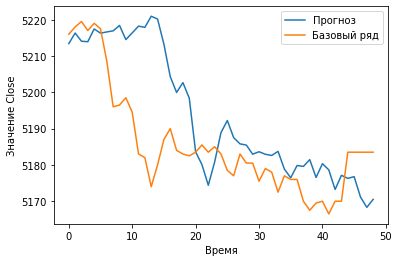

***************************************************


In [ ]:
# Построим графики сравнения предсказания с оригинальным сигналом
# по всем 10 шагам предсказания (10 графиков на разных отдельных осях).
for n in range(10):
  print("***************************************************")
  print("Прогнозирование на {} шаг(а/ов) вперед:".format(n+1))
  showPredict(0, 100, n, predVal2, yValUnscaled2)
  print("***************************************************")

***************************************************
Прогнозирование на 1 шаг(а/ов) вперед:


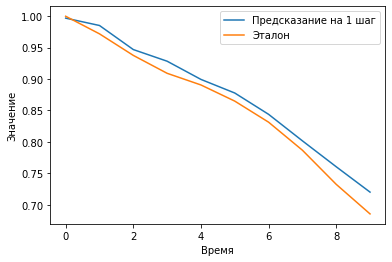

***************************************************
***************************************************
Прогнозирование на 2 шаг(а/ов) вперед:


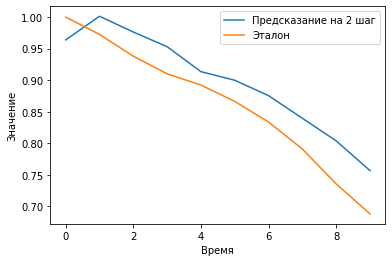

***************************************************
***************************************************
Прогнозирование на 3 шаг(а/ов) вперед:


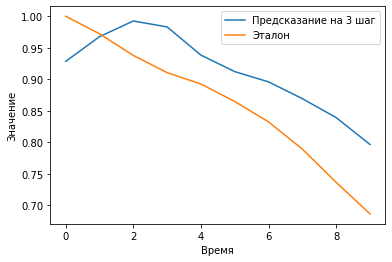

***************************************************
***************************************************
Прогнозирование на 4 шаг(а/ов) вперед:


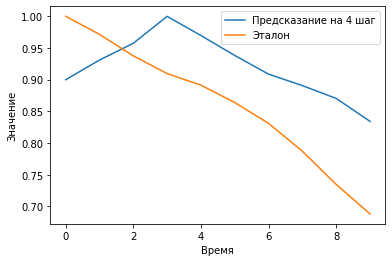

***************************************************
***************************************************
Прогнозирование на 5 шаг(а/ов) вперед:


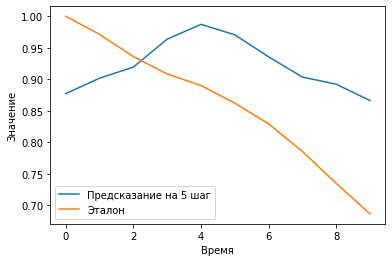

***************************************************
***************************************************
Прогнозирование на 6 шаг(а/ов) вперед:


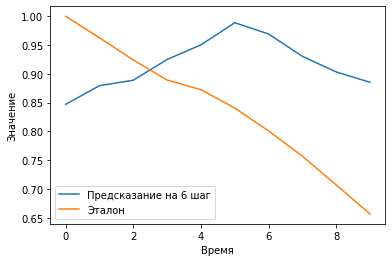

***************************************************
***************************************************
Прогнозирование на 7 шаг(а/ов) вперед:


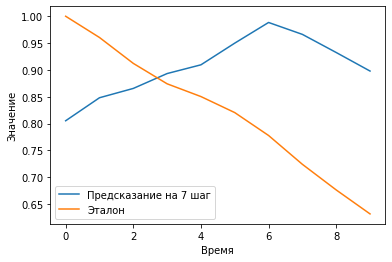

***************************************************
***************************************************
Прогнозирование на 8 шаг(а/ов) вперед:


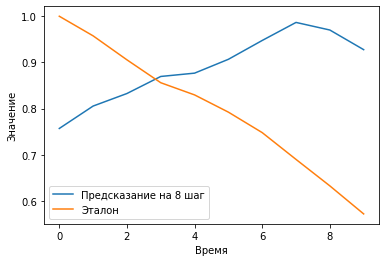

***************************************************
***************************************************
Прогнозирование на 9 шаг(а/ов) вперед:


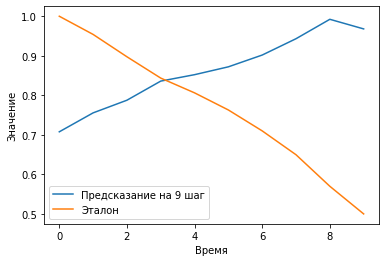

***************************************************
***************************************************
Прогнозирование на 10 шаг(а/ов) вперед:


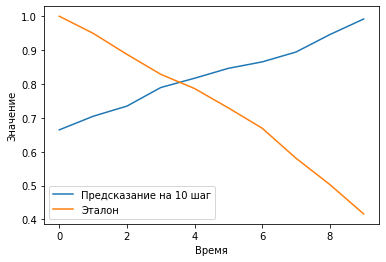

***************************************************


In [ ]:
#Отображаем корреляцию по всех 10 шагам
for n in range(10):
  print("***************************************************")
  print("Прогнозирование на {} шаг(а/ов) вперед:".format(n+1))
  showCorr([n, ], 10, predVal2, yValUnscaled2)
  print("***************************************************")

#### Одномерная свёртка (Conv1D)





Epoch 1/50
939/939 [==============================] - 6s 6ms/step - loss: 0.0030 - val_loss: 1.3490e-04
Epoch 2/50
939/939 [==============================] - 6s 6ms/step - loss: 1.7577e-04 - val_loss: 1.9328e-04
Epoch 3/50
939/939 [==============================] - 6s 6ms/step - loss: 2.5725e-04 - val_loss: 3.1560e-04
Epoch 4/50
939/939 [==============================] - 6s 6ms/step - loss: 1.9900e-04 - val_loss: 8.1756e-05
Epoch 5/50
939/939 [==============================] - 6s 6ms/step - loss: 2.7914e-04 - val_loss: 1.0880e-04
Epoch 6/50
939/939 [==============================] - 6s 6ms/step - loss: 2.1116e-04 - val_loss: 8.7674e-05
Epoch 7/50
939/939 [==============================] - 6s 6ms/step - loss: 2.2685e-04 - val_loss: 1.2611e-04
Epoch 8/50
939/939 [==============================] - 6s 6ms/step - loss: 2.4262e-04 - val_loss: 8.4153e-04
Epoch 9/50
939/939 [==============================] - 6s 6ms/step - loss: 2.4652e-04 - val_loss: 1.1244e-04
Epoch 10/50
939/939 [===========

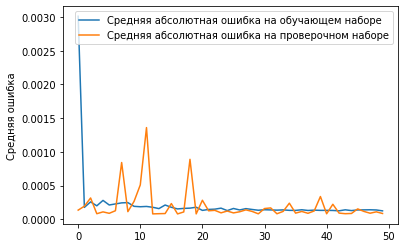

In [ ]:
# Создаем модель
modelC = Sequential()

modelC.add(Conv1D(200, 5, input_shape = (xLen,5), activation="linear"))
modelC.add(GlobalMaxPooling1D())
modelC.add(Dense(100, activation="linear"))
modelC.add(Dense(1, activation="linear"))

# Компилируем
modelC.compile(loss="mse", optimizer=Adam(lr=1e-4))

# Обучаем
history = modelC.fit_generator(trainDataGen,
                    epochs=50, 
                    verbose=1,
                    validation_data=testDataGen)

# Визуализируем результаты
plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

##### Визуализация результатов

In [ ]:
#Создадим генератор проверочной выборки, из которой потом вытащим xVal, yVal для проверки
DataGen = TimeseriesGenerator(xTest, yTest,
                               length=300, sampling_rate=1,
                               batch_size=len(xTest)) #размер batch будет равен длине нашей выборки
xVal = []
yVal = []
for i in DataGen:
  xVal.append(i[0])
  yVal.append(i[1])

xVal = np.array(xVal)
yVal = np.array(yVal)

In [ ]:
#Прогнозируем данные текущей сетью
currModel = modelC
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], yScaler)

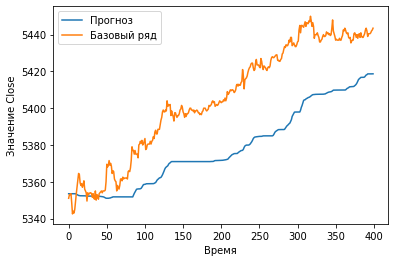

In [ ]:
#Отображаем графики
showPredict(10000, 400, 0, predVal, yValUnscaled)

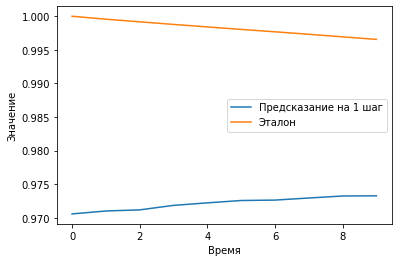

In [ ]:
#Отображаем корреляцию
showCorr([0], 10, predVal, yValUnscaled)

##### Прогнозирование на 10 шагов вперёд

In [ ]:
#Формируем параметры загрузки данных
xLen = 20                       #Анализируем по 20 прошедшим точкам 
valLen = 100                    #Используем 100 записей для проверки
stepsForward = 10
trainLen = data.shape[0]-valLen #Размер тренировочной выборки

#Делим данные на тренировочную и тестовую выборки 
xTrain,xTest = data[:trainLen-stepsForward], data[trainLen+xLen+2:-stepsForward+1]

#Масштабируем данные (отдельно для X и Y), чтобы их легче было скормить сетке
xScaler = StandardScaler()
xScaler.fit(xTrain)
xTrain = xScaler.transform(xTrain)
xTest = xScaler.transform(xTest)

#Для подготовки yTrain на 10 шагов вперед необходимо создать дополнительный датасет
yTrain = np.array([data[:trainLen,0][i:i+stepsForward] for i in range(trainLen-stepsForward)])
yTest = np.array([data[trainLen+xLen+2:,0][i:i+stepsForward] for i in range(valLen-xLen-stepsForward-1)])
yScaler = StandardScaler()
yScaler.fit(yTrain)
yTrain = yScaler.transform(yTrain)
yTest = yScaler.transform(yTest)

#Создаем генератор для обучения
trainDataGen = TimeseriesGenerator(xTrain, yTrain,           #В качестве параметров наши выборки
                               length=xLen, sampling_rate=1, #Для каждой точки
                               batch_size=20)                #Размер batch, который будем скармливать модели

#Создаем аналогичный генератор для валидации при обучении
testDataGen = TimeseriesGenerator(xTest, yTest,
                               length=xLen, sampling_rate=1,
                               batch_size=20)

In [ ]:
print(trainDataGen[10][0].shape,
      trainDataGen[10][1].shape)

(20, 20, 5) (20, 10)


In [ ]:
#Создадим генератор проверочной выборки, из которой потом вытащим xVal, yVal для проверки
DataGen = TimeseriesGenerator(xTest, yTest,
                               length=xLen, sampling_rate=1,
                               batch_size=len(xTest)) #Размер batch будет равен длине нашей выборки

xVal = []
yVal = []
for i in DataGen:
  xVal.append(i[0])
  yVal.append(i[1])

xVal = np.array(xVal)
yVal = np.array(yVal)

**Обучаем Conv1D сеть**

Epoch 1/50
10891/10891 [==============================] - 24s 2ms/step - loss: 0.0094 - val_loss: 0.0026
Epoch 2/50
10891/10891 [==============================] - 23s 2ms/step - loss: 0.0202 - val_loss: 8.9545e-04
Epoch 3/50
10891/10891 [==============================] - 24s 2ms/step - loss: 0.0327 - val_loss: 7.8019e-04
Epoch 4/50
10891/10891 [==============================] - 23s 2ms/step - loss: 0.0097 - val_loss: 0.0010
Epoch 5/50
10891/10891 [==============================] - 23s 2ms/step - loss: 0.0091 - val_loss: 6.2274e-04
Epoch 6/50
10891/10891 [==============================] - 23s 2ms/step - loss: 0.0077 - val_loss: 8.0894e-04
Epoch 7/50
10891/10891 [==============================] - 24s 2ms/step - loss: 0.0145 - val_loss: 8.6280e-04
Epoch 8/50
10891/10891 [==============================] - 24s 2ms/step - loss: 0.0029 - val_loss: 6.4951e-04
Epoch 9/50
10891/10891 [==============================] - 23s 2ms/step - loss: 0.0035 - val_loss: 7.9270e-04
Epoch 10/50
10891/10891 [==

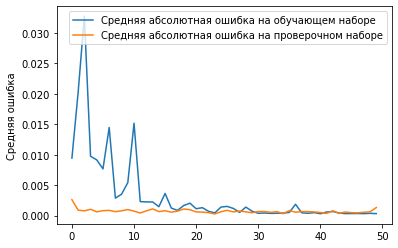

In [ ]:
#Создаем модель
modelC2 = Sequential()

modelC2.add(Conv1D(200, 5, input_shape = (xLen,xTrain.shape[1]), activation="linear"))
modelC2.add(GlobalMaxPooling1D())
modelC2.add(Dense(100, activation="linear"))
modelC2.add(Dense(yTrain.shape[1], activation="linear"))

# Компилируем
modelC2.compile(loss="mse", optimizer=Adam(lr=1e-4))

# Обучаем
history = modelC2.fit_generator(trainDataGen,
                    epochs=50, 
                    verbose=1,
                    validation_data=testDataGen)

# Визуализируем результаты
plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [ ]:
# Дообучаем
modelC2.compile(loss="mse", optimizer=Adam(lr=1e-5))
history = modelC2.fit_generator(
                    trainDataGen, 
                    epochs=20, 
                    verbose=1, 
                    validation_data = testDataGen 
                    )

Epoch 1/20
10891/10891 [==============================] - 24s 2ms/step - loss: 6.4170e-04 - val_loss: 4.9492e-04
Epoch 2/20
10891/10891 [==============================] - 24s 2ms/step - loss: 1.9197e-04 - val_loss: 5.8823e-04
Epoch 3/20
10891/10891 [==============================] - 24s 2ms/step - loss: 1.8671e-04 - val_loss: 4.9327e-04
Epoch 4/20
10891/10891 [==============================] - 24s 2ms/step - loss: 1.8318e-04 - val_loss: 5.7305e-04
Epoch 5/20
10891/10891 [==============================] - 24s 2ms/step - loss: 1.8004e-04 - val_loss: 5.1198e-04
Epoch 6/20
10891/10891 [==============================] - 24s 2ms/step - loss: 1.8000e-04 - val_loss: 6.1355e-04
Epoch 7/20
10891/10891 [==============================] - 24s 2ms/step - loss: 1.7910e-04 - val_loss: 5.9398e-04
Epoch 8/20
10891/10891 [==============================] - 24s 2ms/step - loss: 1.7886e-04 - val_loss: 4.8276e-04
Epoch 9/20
10891/10891 [==============================] - 24s 2ms/step - loss: 1.7771e-04 - val_

##### **Отображаем результаты** (10 графиков на разных отдельных осях)

In [ ]:
# Прогнозируем данные текущей сетью
currModel2 = modelC2
(predVal2, yValUnscaled2) = getPred(currModel2, xVal[0], yVal[0], yScaler)

***************************************************
Прогнозирование на 1 шаг(а/ов) вперед:


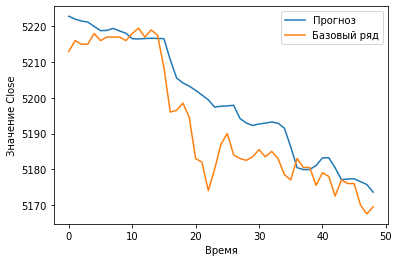

***************************************************
***************************************************
Прогнозирование на 2 шаг(а/ов) вперед:


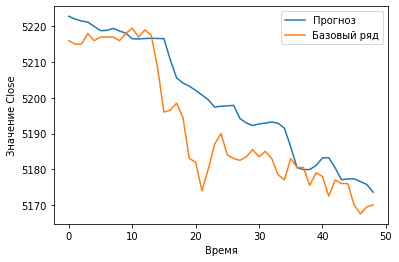

***************************************************
***************************************************
Прогнозирование на 3 шаг(а/ов) вперед:


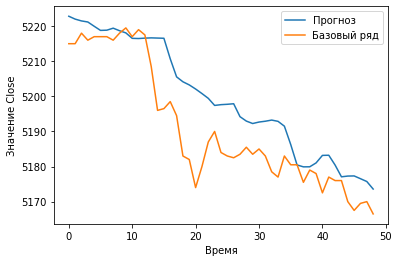

***************************************************
***************************************************
Прогнозирование на 4 шаг(а/ов) вперед:


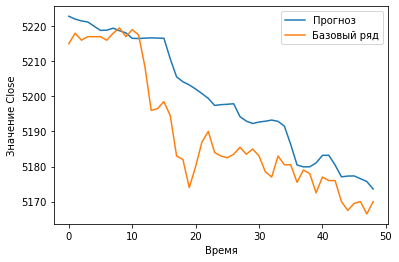

***************************************************
***************************************************
Прогнозирование на 5 шаг(а/ов) вперед:


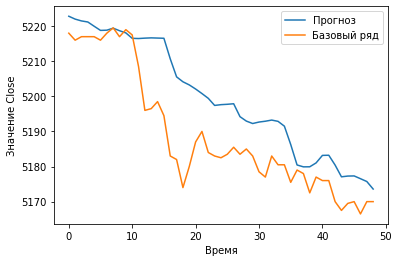

***************************************************
***************************************************
Прогнозирование на 6 шаг(а/ов) вперед:


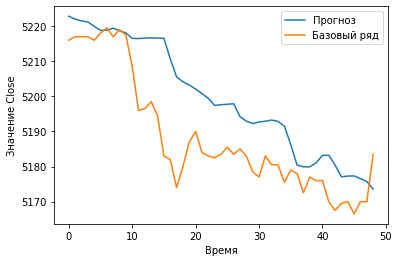

***************************************************
***************************************************
Прогнозирование на 7 шаг(а/ов) вперед:


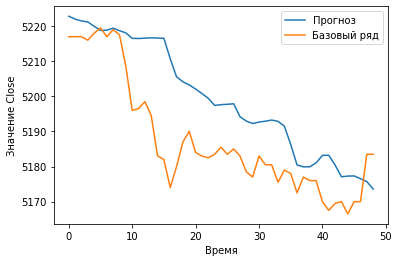

***************************************************
***************************************************
Прогнозирование на 8 шаг(а/ов) вперед:


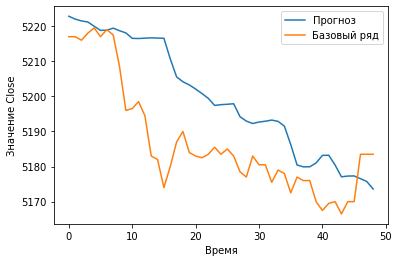

***************************************************
***************************************************
Прогнозирование на 9 шаг(а/ов) вперед:


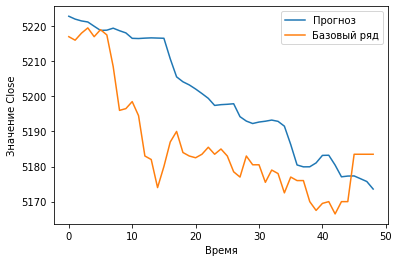

***************************************************
***************************************************
Прогнозирование на 10 шаг(а/ов) вперед:


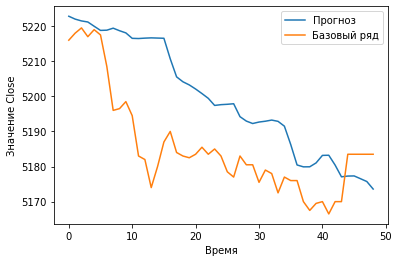

***************************************************


In [ ]:
# Построим графики сравнения предсказания с оригинальным сигналом
# по всем 10 шагам предсказания (10 графиков на разных отдельных осях).
for n in range(10):
  print("***************************************************")
  print("Прогнозирование на {} шаг(а/ов) вперед:".format(n+1))
  showPredict(0, 100, n, predVal2, yValUnscaled2)
  print("***************************************************")

***************************************************
Прогнозирование на 1 шаг(а/ов) вперед:


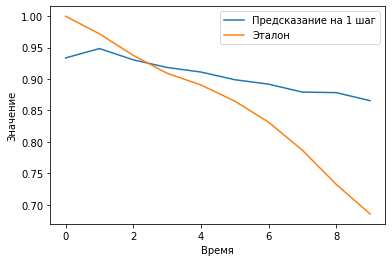

***************************************************
***************************************************
Прогнозирование на 2 шаг(а/ов) вперед:


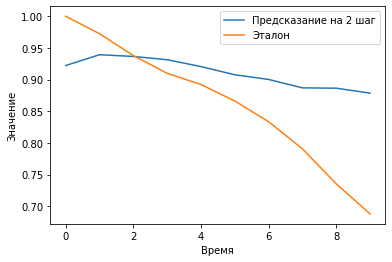

***************************************************
***************************************************
Прогнозирование на 3 шаг(а/ов) вперед:


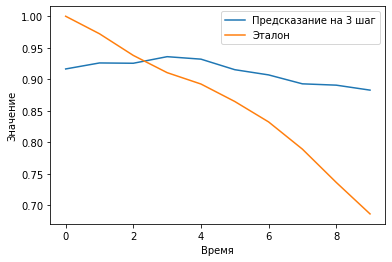

***************************************************
***************************************************
Прогнозирование на 4 шаг(а/ов) вперед:


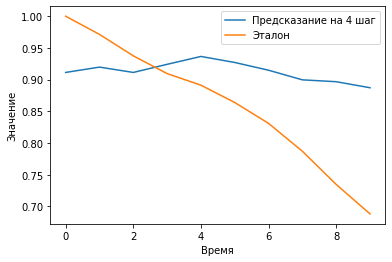

***************************************************
***************************************************
Прогнозирование на 5 шаг(а/ов) вперед:


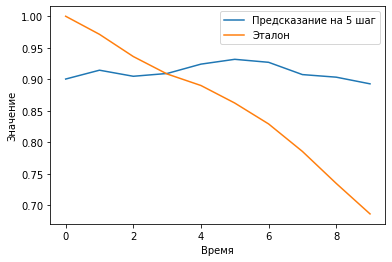

***************************************************
***************************************************
Прогнозирование на 6 шаг(а/ов) вперед:


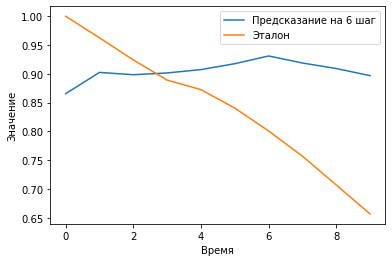

***************************************************
***************************************************
Прогнозирование на 7 шаг(а/ов) вперед:


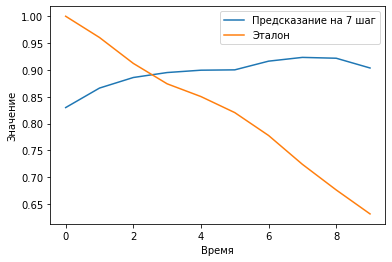

***************************************************
***************************************************
Прогнозирование на 8 шаг(а/ов) вперед:


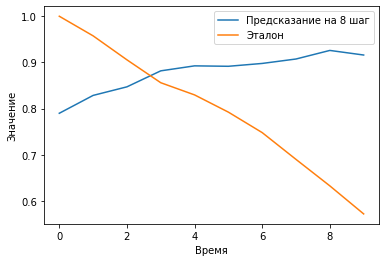

***************************************************
***************************************************
Прогнозирование на 9 шаг(а/ов) вперед:


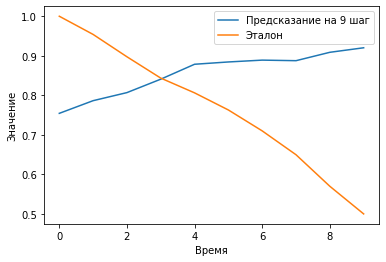

***************************************************
***************************************************
Прогнозирование на 10 шаг(а/ов) вперед:


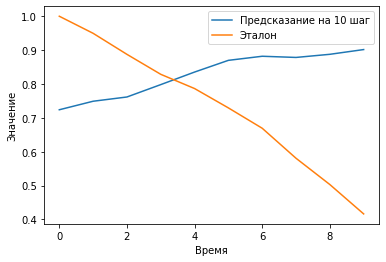

***************************************************


In [ ]:
#Отображаем корреляцию по всех 10 шагам
for n in range(10):
  print("***************************************************")
  print("Прогнозирование на {} шаг(а/ов) вперед:".format(n+1))
  showCorr([n, ], 10, predVal2, yValUnscaled2)
  print("***************************************************")

#### LSTM


Epoch 1/70
939/939 [==============================] - 13s 14ms/step - loss: 0.3368 - val_loss: 0.4911
Epoch 2/70
939/939 [==============================] - 13s 14ms/step - loss: 0.2567 - val_loss: 0.3683
Epoch 3/70
939/939 [==============================] - 13s 14ms/step - loss: 0.1810 - val_loss: 0.2496
Epoch 4/70
939/939 [==============================] - 13s 14ms/step - loss: 0.1128 - val_loss: 0.1446
Epoch 5/70
939/939 [==============================] - 13s 13ms/step - loss: 0.0606 - val_loss: 0.0689
Epoch 6/70
939/939 [==============================] - 13s 13ms/step - loss: 0.0307 - val_loss: 0.0285
Epoch 7/70
939/939 [==============================] - 12s 13ms/step - loss: 0.0191 - val_loss: 0.0127
Epoch 8/70
939/939 [==============================] - 13s 13ms/step - loss: 0.0151 - val_loss: 0.0070
Epoch 9/70
939/939 [==============================] - 13s 14ms/step - loss: 0.0129 - val_loss: 0.0048
Epoch 10/70
939/939 [==============================] - 13s 13ms/step - loss: 0.010

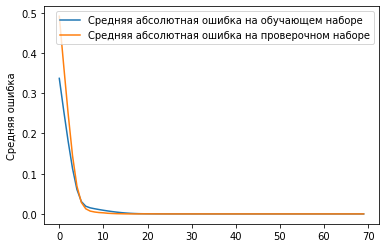

In [ ]:
import tensorflow

# Создаем модель
modelL = Sequential()

modelL.add(LSTM(5, input_shape = (xLen, 5)))
modelL.add(Dense(10, activation="linear"))
modelL.add(Dense(1, activation="linear"))

#Компилируем
modelL.compile(loss="mse", optimizer=Adam(lr=1e-5))

# Обучаем
history = modelL.fit_generator(trainDataGen, 
                    epochs=70, 
                    verbose=1,
                    validation_data=testDataGen)

# Визуализируем результаты
plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

##### Визуализация результатов

In [ ]:
#Создадим генератор проверочной выборки, из которой потом вытащим xVal, yVal для проверки
DataGen = TimeseriesGenerator(xTest, yTest,
                               length=300, sampling_rate=1,
                               batch_size=len(xTest)) #размер batch будет равен длине нашей выборки
xVal = []
yVal = []
for i in DataGen:
  xVal.append(i[0])
  yVal.append(i[1])

xVal = np.array(xVal)
yVal = np.array(yVal)

In [ ]:
#Прогнозируем данные текущей сетью
currModel = modelL
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], yScaler)

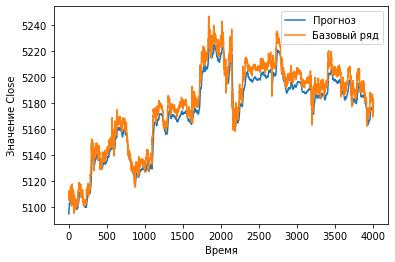

In [ ]:
#Отображаем графики
showPredict(0, 4000, 0, predVal, yValUnscaled)

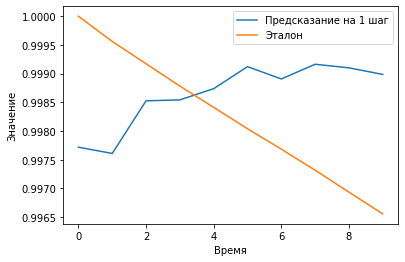

In [ ]:
#Отображаем корреляцию
showCorr([0], 10, predVal, yValUnscaled)

##### Прогнозирование на 10 шагов вперёд

In [ ]:
#Формируем параметры загрузки данных
xLen = 20                       #Анализируем по 20 прошедшим точкам 
valLen = 100                    #Используем 100 записей для проверки
stepsForward = 10
trainLen = data.shape[0]-valLen #Размер тренировочной выборки

#Делим данные на тренировочную и тестовую выборки 
xTrain,xTest = data[:trainLen-stepsForward], data[trainLen+xLen+2:-stepsForward+1]

#Масштабируем данные (отдельно для X и Y), чтобы их легче было скормить сетке
xScaler = StandardScaler()
xScaler.fit(xTrain)
xTrain = xScaler.transform(xTrain)
xTest = xScaler.transform(xTest)

#Для подготовки yTrain на 10 шагов вперед необходимо создать дополнительный датасет
yTrain = np.array([data[:trainLen,0][i:i+stepsForward] for i in range(trainLen-stepsForward)])
yTest = np.array([data[trainLen+xLen+2:,0][i:i+stepsForward] for i in range(valLen-xLen-stepsForward-1)])
yScaler = StandardScaler()
yScaler.fit(yTrain)
yTrain = yScaler.transform(yTrain)
yTest = yScaler.transform(yTest)

#Создаем генератор для обучения
trainDataGen = TimeseriesGenerator(xTrain, yTrain,           #В качестве параметров наши выборки
                               length=xLen, sampling_rate=1, #Для каждой точки
                               batch_size=20)                #Размер batch, который будем скармливать модели

#Создаем аналогичный генератор для валидации при обучении
testDataGen = TimeseriesGenerator(xTest, yTest,
                               length=xLen, sampling_rate=1,
                               batch_size=20)

In [ ]:
print(trainDataGen[10][0].shape,
      trainDataGen[10][1].shape)

(20, 20, 5) (20, 10)


In [ ]:
#Создадим генератор проверочной выборки, из которой потом вытащим xVal, yVal для проверки
DataGen = TimeseriesGenerator(xTest, yTest,
                               length=xLen, sampling_rate=1,
                               batch_size=len(xTest)) #Размер batch будет равен длине нашей выборки

xVal = []
yVal = []
for i in DataGen:
  xVal.append(i[0])
  yVal.append(i[1])

xVal = np.array(xVal)
yVal = np.array(yVal)

**Обучаем LSTM сеть**

Epoch 1/70
10891/10891 [==============================] - 36s 3ms/step - loss: 0.7871 - val_loss: 0.1728
Epoch 2/70
10891/10891 [==============================] - 37s 3ms/step - loss: 0.3126 - val_loss: 0.0432
Epoch 3/70
10891/10891 [==============================] - 37s 3ms/step - loss: 0.1052 - val_loss: 0.0230
Epoch 4/70
10891/10891 [==============================] - 36s 3ms/step - loss: 0.0365 - val_loss: 0.0150
Epoch 5/70
10891/10891 [==============================] - 37s 3ms/step - loss: 0.0133 - val_loss: 0.0063
Epoch 6/70
10891/10891 [==============================] - 39s 4ms/step - loss: 0.0058 - val_loss: 0.0037
Epoch 7/70
10891/10891 [==============================] - 38s 3ms/step - loss: 0.0033 - val_loss: 0.0021
Epoch 8/70
10891/10891 [==============================] - 38s 3ms/step - loss: 0.0021 - val_loss: 0.0015
Epoch 9/70
10891/10891 [==============================] - 37s 3ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 10/70
10891/10891 [==============================

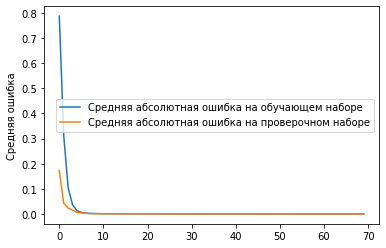

In [ ]:
# Создаем модель
modelL2 = Sequential()

modelL2.add(LSTM(5, input_shape = (xLen,xTrain.shape[1])))
modelL2.add(Dense(10, activation="linear"))
modelL2.add(Dense(yTrain.shape[1], activation="linear"))

# Компилируем
modelL2.compile(loss="mse", optimizer=Adam(lr=1e-5))

# Обучаем
history = modelL2.fit_generator(trainDataGen, 
                    epochs=70, 
                    verbose=1,
                    validation_data=testDataGen)

# Визуализируем результаты
plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [ ]:
# Дообучаем
modelL2.compile(loss="mse", optimizer=Adam(lr=1e-5))
history = modelL2.fit_generator(
                    trainDataGen, 
                    epochs=20, 
                    verbose=1, 
                    validation_data = testDataGen 
                    )

Epoch 1/20
10891/10891 [==============================] - 37s 3ms/step - loss: 1.2179e-04 - val_loss: 3.8961e-04
Epoch 2/20
10891/10891 [==============================] - 37s 3ms/step - loss: 1.2131e-04 - val_loss: 3.9395e-04
Epoch 3/20
10891/10891 [==============================] - 37s 3ms/step - loss: 1.2049e-04 - val_loss: 3.6966e-04
Epoch 4/20
10891/10891 [==============================] - 37s 3ms/step - loss: 1.1996e-04 - val_loss: 4.0356e-04
Epoch 5/20
10891/10891 [==============================] - 37s 3ms/step - loss: 1.1936e-04 - val_loss: 3.7906e-04
Epoch 6/20
10891/10891 [==============================] - 38s 3ms/step - loss: 1.1904e-04 - val_loss: 3.9350e-04
Epoch 7/20
10891/10891 [==============================] - 37s 3ms/step - loss: 1.1849e-04 - val_loss: 3.8604e-04
Epoch 8/20
10891/10891 [==============================] - 39s 4ms/step - loss: 1.1846e-04 - val_loss: 3.9101e-04
Epoch 9/20
10891/10891 [==============================] - 38s 3ms/step - loss: 1.1785e-04 - val_

##### **Отображаем результаты** (10 графиков на разных отдельных осях)

In [ ]:
# Прогнозируем данные текущей сетью
currModel3 = modelL2
(predVal2, yValUnscaled2) = getPred(currModel3, xVal[0], yVal[0], yScaler)

***************************************************
Прогнозирование на 1 шаг(а/ов) вперед:


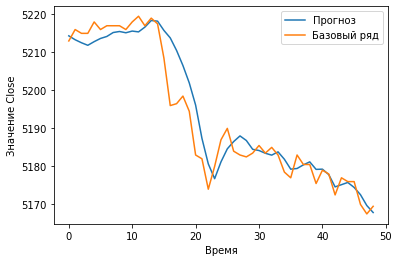

***************************************************
***************************************************
Прогнозирование на 2 шаг(а/ов) вперед:


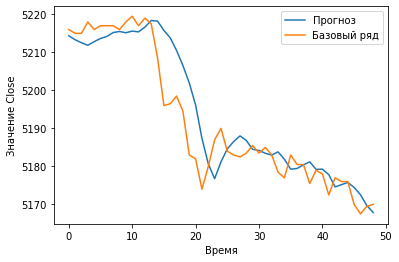

***************************************************
***************************************************
Прогнозирование на 3 шаг(а/ов) вперед:


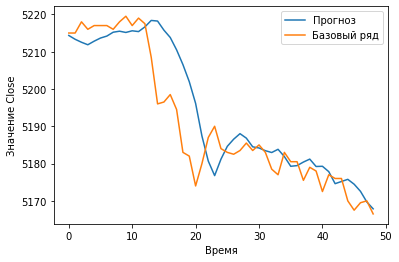

***************************************************
***************************************************
Прогнозирование на 4 шаг(а/ов) вперед:


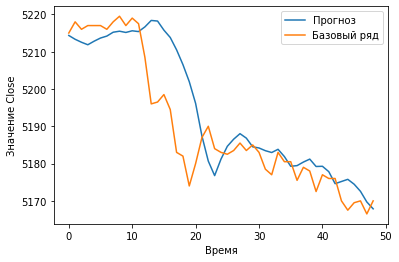

***************************************************
***************************************************
Прогнозирование на 5 шаг(а/ов) вперед:


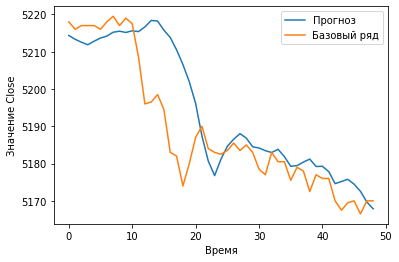

***************************************************
***************************************************
Прогнозирование на 6 шаг(а/ов) вперед:


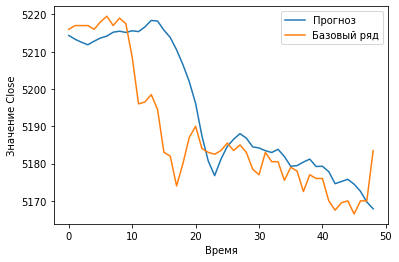

***************************************************
***************************************************
Прогнозирование на 7 шаг(а/ов) вперед:


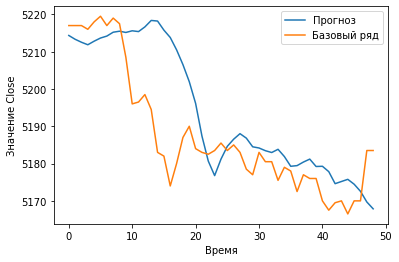

***************************************************
***************************************************
Прогнозирование на 8 шаг(а/ов) вперед:


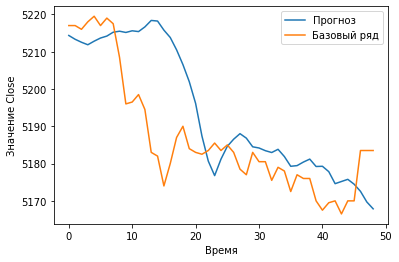

***************************************************
***************************************************
Прогнозирование на 9 шаг(а/ов) вперед:


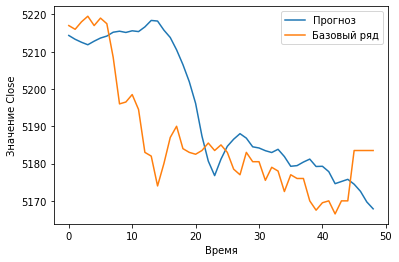

***************************************************
***************************************************
Прогнозирование на 10 шаг(а/ов) вперед:


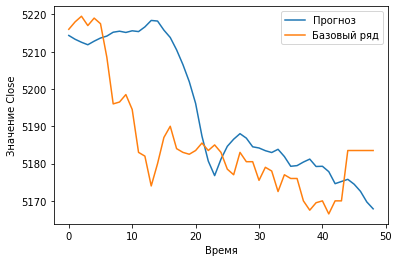

***************************************************


In [ ]:
# Построим графики сравнения предсказания с оригинальным сигналом
# по всем 10 шагам предсказания (10 графиков на разных отдельных осях).
for n in range(10):
  print("***************************************************")
  print("Прогнозирование на {} шаг(а/ов) вперед:".format(n+1))
  showPredict(0, 100, n, predVal2, yValUnscaled2)
  print("***************************************************")

***************************************************
Прогнозирование на 1 шаг(а/ов) вперед:


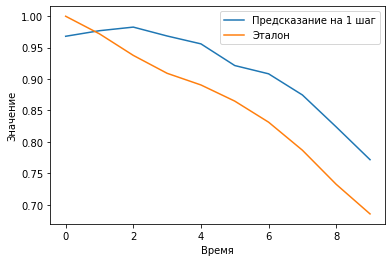

***************************************************
***************************************************
Прогнозирование на 2 шаг(а/ов) вперед:


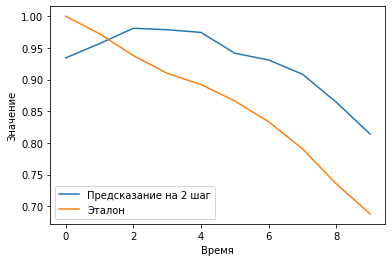

***************************************************
***************************************************
Прогнозирование на 3 шаг(а/ов) вперед:


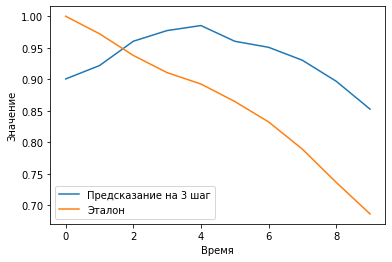

***************************************************
***************************************************
Прогнозирование на 4 шаг(а/ов) вперед:


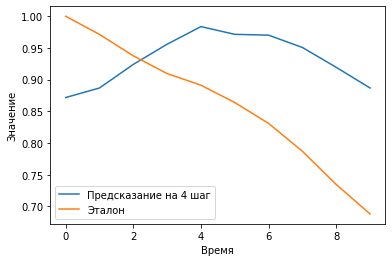

***************************************************
***************************************************
Прогнозирование на 5 шаг(а/ов) вперед:


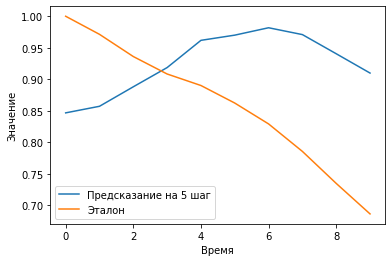

***************************************************
***************************************************
Прогнозирование на 6 шаг(а/ов) вперед:


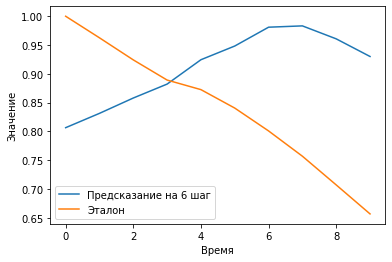

***************************************************
***************************************************
Прогнозирование на 7 шаг(а/ов) вперед:


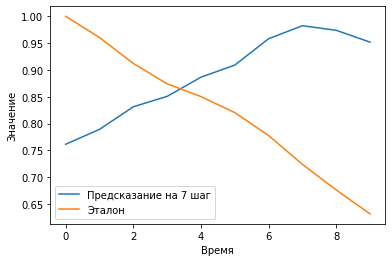

***************************************************
***************************************************
Прогнозирование на 8 шаг(а/ов) вперед:


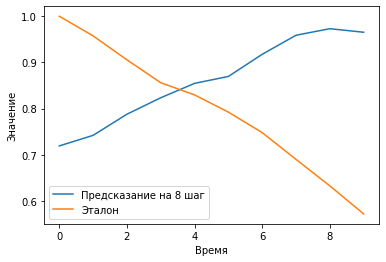

***************************************************
***************************************************
Прогнозирование на 9 шаг(а/ов) вперед:


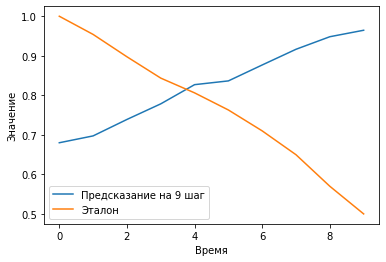

***************************************************
***************************************************
Прогнозирование на 10 шаг(а/ов) вперед:


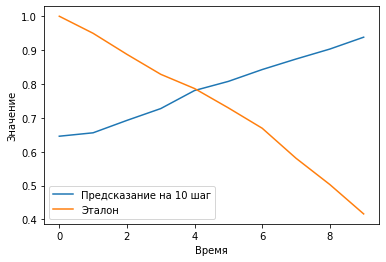

***************************************************


In [ ]:
#Отображаем корреляцию по всех 10 шагам
for n in range(10):
  print("***************************************************")
  print("Прогнозирование на {} шаг(а/ов) вперед:".format(n+1))
  showCorr([n, ], 10, predVal2, yValUnscaled2)
  print("***************************************************")

## **PRO**

### **Вариант 1**

**Задание:**

База Лукойл

Сделайте сложную сеть с предсказанием на один шаг и valLen = 30000 из LSTM, Conv1D и/или Dense слоёв, так, чтобы корреляция на старте была 99,9% и строго убывала


In [ ]:
#Загружаем библиотеки

import pandas as pd #Пандас
import matplotlib.pyplot as plt #Отрисовка графиков
from tensorflow.keras import utils #Для to_categorical
import numpy as np #Numpy
from tensorflow.keras.optimizers import Adam #Оптимизатор
from tensorflow.keras.models import Sequential, Model #Два варианты моделей
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM, GlobalMaxPooling1D #Стандартные слои
from sklearn.preprocessing import StandardScaler, MinMaxScaler #Нормировщики
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator # для генерации выборки временных рядов

# Рисовать графики сразу же
%matplotlib inline

In [ ]:
#Считываем данные с помощью pandas
base_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Базы/Акции Лукойл/18_19.csv', sep=';')

In [ ]:
#Выводим пять первых строк
base_data.head()

,DATE,TIME,OPEN,MAX,MIN,CLOSE,VOLUME
0,03.01.2018,10:00:00,3341.0,3356.0,3340.0,3355.0,6088
1,03.01.2018,10:01:00,3355.0,3359.0,3353.0,3353.0,1624
2,03.01.2018,10:02:00,3351.5,3357.5,3351.5,3357.5,722
3,03.01.2018,10:03:00,3354.5,3360.0,3354.5,3358.0,3034
4,03.01.2018,10:04:00,3358.0,3360.0,3351.5,3360.0,1427


In [ ]:
#Выцепялем numpy значения .values
#И выводим нулевой
txt = base_data.values[0]
print(txt)

['03.01.2018' '10:00:00' 3341.0 3356.0 3340.0 3355.0 6088]


In [ ]:
base_data18 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Базы/Акции Лукойл/18_19.csv', sep=';')
base_data16 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Базы/Акции Лукойл/16_17.csv', sep=';')
base_data14 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Базы/Акции Лукойл/14_15.csv', sep=';')
base_data12 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Базы/Акции Лукойл/12_13.csv', sep=';')
data18_19 = base_data18.iloc[:,2:]
data16_17 = base_data16.iloc[:,2:]
data14_15 = base_data14.iloc[:,2:]
data12_13 = base_data12.iloc[:,2:]

In [ ]:
# Выводим параметры одного файла
d = data18_19
print(len(d)) # Сколько есть записей
print(len(d.iloc[0])) # Длина одной строки данных
print(d.iloc[0]) # Пример первой строки данных

217947
5
OPEN      3341.0
MAX       3356.0
MIN       3340.0
CLOSE     3355.0
VOLUME    6088.0
Name: 0, dtype: float64


In [ ]:
# Объединяем базы
data = pd.concat([data12_13, data14_15, data16_17,data18_19]) 

# Превращаем в numpy массив
data = np.array(data)                   

# Сравниваем размеры
print(len(data16_17)) # Выводим размер 1й базы
print(len(data18_19)) # Выводим размер 2й базы
print(len(data14_15)) # Выводим размер 3й базы
print(len(data12_13)) # Выводим размер 4й базы
print(len(data))      # Выводим размер суммарной базы

263925
217947
261703
264718
1008293


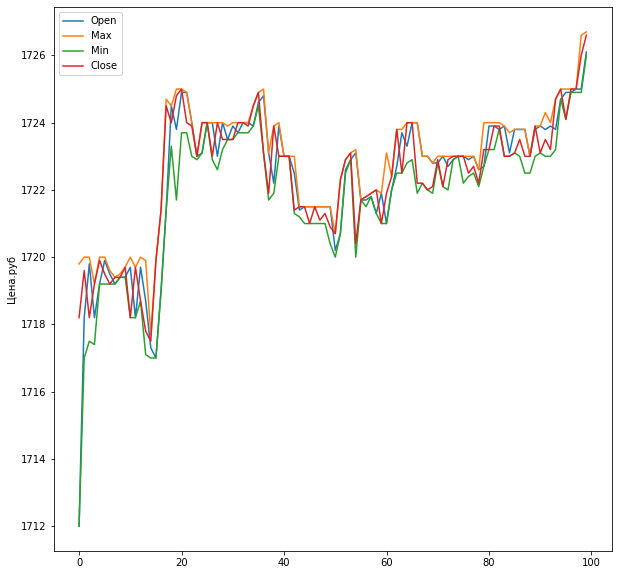

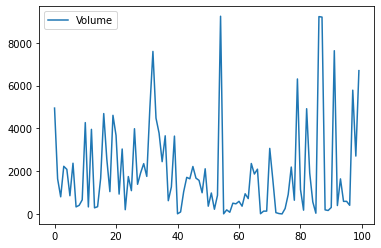

In [ ]:
plt.figure(figsize=(10,10))
#Отображаем исходные от точки start и длинной stop
start = 0            #С какой точки начинаем
stop = 100           #Сколько точек отрисуем

#Заполняем текстовые названия каналов данных
chanelNames = ['Open', 'Max', 'Min', 'Close', 'Volume']

#Рисуем все графики данных
#4 основных канала - open, max, min, close
for i in range(4):
  #Отрисовываем часть данных
  #От начальной точки, до начальной точки + размер шага отрисовки
  plt.plot(data[start:start+stop,i], 
          label=chanelNames[i])
plt.ylabel('Цена.руб')
plt.legend()
plt.show()

#Канал volume
plt.plot(data[start:start+stop,4], label="Volume")
plt.legend()
plt.show()

In [ ]:
#Формируем параметры загрузки данных

xLen = 300                      #Анализируем по 300 прошедшим точкам 
valLen = 30000                  #Используем 30.000 записей для проверки

trainLen = data.shape[0]-valLen # Размер тренировочной выборки

#Делим данные на тренировочную и тестовую выборки 
xTrain,xTest = data[:trainLen], data[trainLen+xLen+2:]

#Масштабируем данные (отдельно для X и Y), чтобы их легче было скормить сетке
xScaler = MinMaxScaler()
xScaler.fit(xTrain)
xTrain = xScaler.transform(xTrain)
xTest = xScaler.transform(xTest)

#Делаем reshape,т.к. у нас только один столбец по одному значению
yTrain,yTest = np.reshape(data[:trainLen,3],(-1,1)), np.reshape(data[trainLen+xLen+2:,3],(-1,1)) 
yScaler = MinMaxScaler()
yScaler.fit(yTrain)
yTrain = yScaler.transform(yTrain)
yTest = yScaler.transform(yTest)

#Создаем генератор для обучения
trainDataGen = TimeseriesGenerator(xTrain, yTrain,           #В качестве параметров наши выборки
                               length=xLen, stride=1, sampling_rate=1, #Для каждой точки (из промежутка длины xLen)
                               batch_size=700)                #Размер batch, который будем скармливать модели

#Создаем аналогичный генератор для валидации при обучении
testDataGen = TimeseriesGenerator(xTest, yTest,
                               length=xLen, stride=1,
                               batch_size=700)

In [ ]:
xTrain[0]

array([0.03546499, 0.03628414, 0.03722029, 0.03694365, 0.00115121])

In [ ]:
print(trainDataGen[0][0].shape,
      trainDataGen[0][1].shape)

(100, 300, 5) (100, 1)


In [ ]:
from tensorflow.keras.utils import plot_model

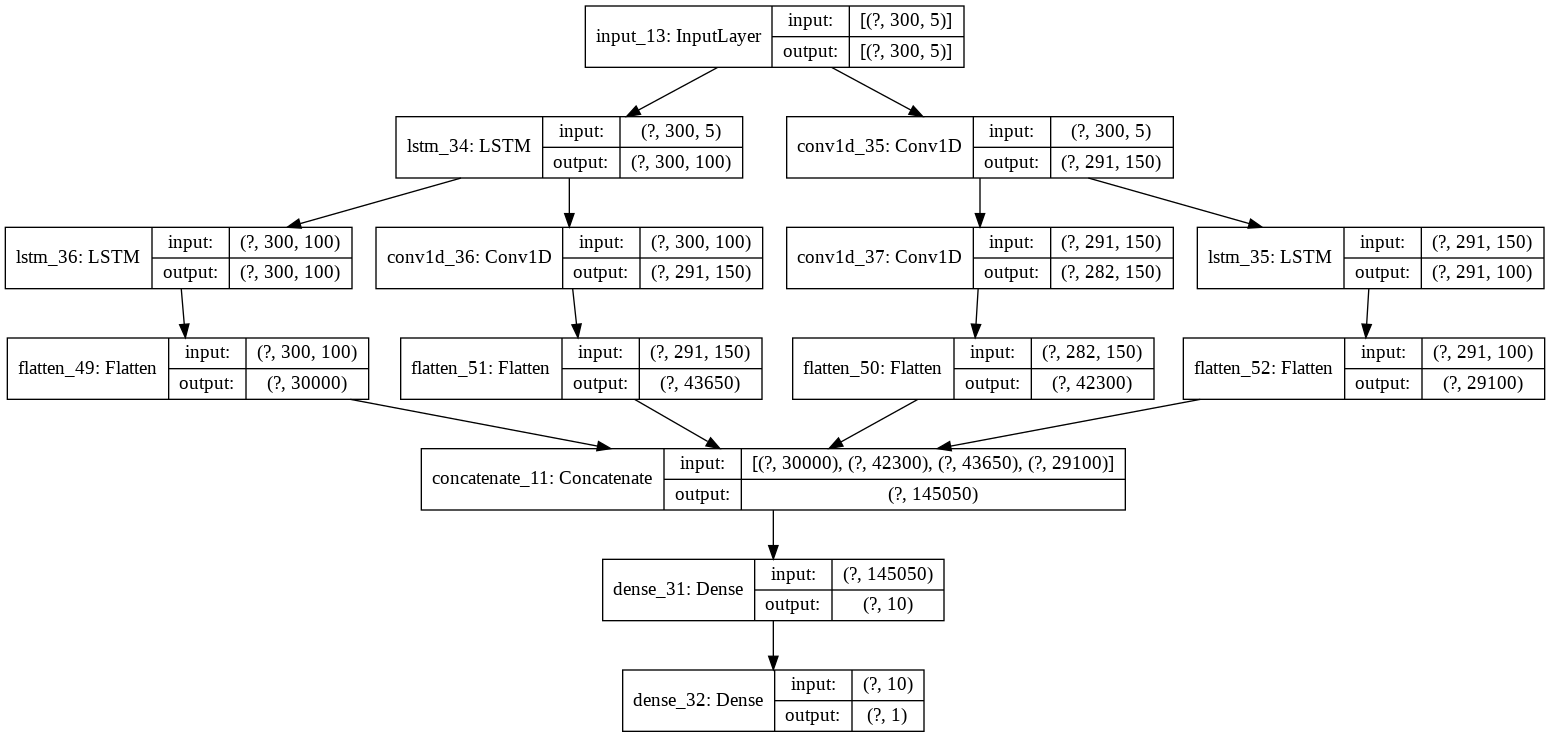

In [ ]:
#Создаем модеть и отрисовываем схему этой модели

dataInput = Input(shape=(trainDataGen[0][0].shape[1], trainDataGen[0][0].shape[2]))

lstmWay = LSTM(100, return_sequences="True")(dataInput)
convWay = Conv1D(150, 10, activation="relu")(dataInput)

lstmConvWay = Conv1D(150, 10, activation="relu")(lstmWay)
convLstmWay = LSTM(100, return_sequences="True")(convWay)

lstmWay = LSTM(100, return_sequences="True")(lstmWay)
convWay = Conv1D(150, 10, activation="relu")(convWay)

lstmWay = Flatten()(lstmWay)
convWay = Flatten()(convWay)
lstmConvWay = Flatten()(lstmConvWay)
convLstmWay = Flatten()(convLstmWay)

finWay = concatenate([lstmWay, convWay, lstmConvWay, convLstmWay])
finWay = Dense(10, activation="linear")(finWay)
finWay = Dense(yTrain.shape[1], activation="linear")(finWay)

modelX = Model(dataInput, finWay)

plot_model(modelX, show_shapes=True, show_layer_names=True)

Epoch 1/20
939/939 [==============================] - 176s 187ms/step - loss: 0.0062 - val_loss: 0.0042
Epoch 2/20
939/939 [==============================] - 177s 189ms/step - loss: 0.0018 - val_loss: 2.4436e-04
Epoch 3/20
939/939 [==============================] - 177s 188ms/step - loss: 0.0011 - val_loss: 2.4639e-04
Epoch 4/20
939/939 [==============================] - 177s 189ms/step - loss: 3.6795e-04 - val_loss: 6.2636e-04
Epoch 5/20
939/939 [==============================] - 177s 188ms/step - loss: 0.0012 - val_loss: 1.7607e-04
Epoch 6/20
939/939 [==============================] - 177s 188ms/step - loss: 2.3852e-04 - val_loss: 7.0786e-04
Epoch 7/20
939/939 [==============================] - 177s 188ms/step - loss: 7.1714e-04 - val_loss: 6.1882e-05
Epoch 8/20
939/939 [==============================] - 177s 188ms/step - loss: 3.3798e-04 - val_loss: 3.7766e-04
Epoch 9/20
939/939 [==============================] - 176s 188ms/step - loss: 1.9712e-04 - val_loss: 3.9297e-05
Epoch 10/20


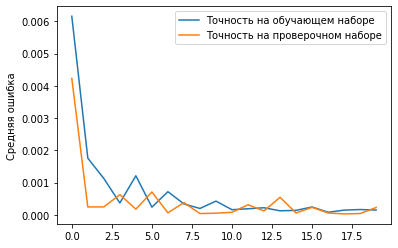

In [ ]:
# Создаем модель уже для обучения
dataInput = Input(shape=(trainDataGen[0][0].shape[1], trainDataGen[0][0].shape[2]))

lstmWay = LSTM(100, return_sequences="True")(dataInput)
convWay = Conv1D(150, 10, activation="relu")(dataInput)

lstmConvWay = Conv1D(150, 10, activation="relu")(lstmWay)
convLstmWay = LSTM(100, return_sequences="True")(convWay)

lstmWay = LSTM(100, return_sequences="True")(lstmWay)
convWay = Conv1D(150, 10, activation="relu")(convWay)

lstmWay = Flatten()(lstmWay)
convWay = Flatten()(convWay)
lstmConvWay = Flatten()(lstmConvWay)
convLstmWay = Flatten()(convLstmWay)

finWay = concatenate([lstmWay, convWay, lstmConvWay, convLstmWay])
finWay = Dense(10, activation="linear")(finWay)
finWay = Dense(yTrain.shape[1], activation="linear")(finWay)

modelX = Model(dataInput, finWay)

# Компилируем
modelX.compile(loss="mse", optimizer=Adam(lr=1e-4))

# Обучаем
history = modelX.fit_generator(trainDataGen, 
                    epochs=25, 
                    verbose=1,
                    validation_data=testDataGen)

# Визуализируем результат
plt.plot(history.history['loss'], 
         label='Точность на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Точность на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [ ]:
# ************************************
# Функции для визуализации результатов
# ************************************

# Функция рассчета результата прогнозирования сети
#***
# В аргументы принимает сеть (currModel) и проверочную выборку
# Выдаёт результаты предсказания predVal
# И правильные ответы в исходной размерности yValUnscaled (какими они были до нормирования)
#***
def getPred(currModel, xVal, yVal, yScaler):
  # Предсказываем ответ сети по проверочной выборке
  # И возвращаем исходны масштаб данных, до нормализации
  predVal = yScaler.inverse_transform(currModel.predict(xVal))
  yValUnscaled = yScaler.inverse_transform(yVal)
  
  return (predVal, yValUnscaled)

# Функция отрисовывающая графики, что предсказала сеть и какие были правильные ответы
#***
# start - точка с которой начинаем отрисовку графика
# step - длина графика, которую отрисовываем
# channel - какой канал отрисовываем
#***
def showPredict(start, step, channel, predVal, yValUnscaled):
  plt.plot(predVal[start:start+step, 0],
           label='Прогноз')
  plt.plot(yValUnscaled[start:start+step, channel], 
           label='Базовый ряд')
  plt.xlabel('Время')
  plt.ylabel('Значение Close')
  plt.legend()
  plt.show()
  
# Функция расчёта корреляции дух одномерных векторов
def correlate(a, b):
  # Рассчитываем основные показатели
  ma = a.mean() # Среднее значение первого вектора
  mb = b.mean() # Среднее значение второго вектора
  mab = (a*b).mean() # Среднее значение произведения векторов
  sa = a.std() # Среднеквадратичное отклонение первого вектора
  sb = b.std() # Среднеквадратичное отклонение второго вектора
  
  #Рассчитываем корреляцию
  val = 1
  if ((sa>0) & (sb>0)):
    val = (mab-ma*mb)/(sa*sb)
  return val

# Функция отображающая на графике корреляцию прогнозированного сигнала с правильным
#***
# Смещая на различное количество шагов назад
# Для проверки появления эффекта автокорреляции
# channels - по каким каналам отображать корреляцию
# corrSteps - на какое количество шагов смещать сигнал назад для рассчёта корреляции
#***
def showCorr(channels, corrSteps, predVal, yValUnscaled):
  # Проходим по всем каналам
  for ch in channels:
    corr = [] # Создаём пустой лист, в нём будут корреляции при смезении на i рагов обратно
    yLen = yValUnscaled.shape[0] # Запоминаем размер проверочной выборки

      # Постепенно увеличикаем шаг, насколько смещаем сигнал для проверки автокорреляции
    for i in range(corrSteps):
      # Получаем сигнал, смещённый на i шагов назад
      # predVal[i:, ch]
      # Сравниваем его с верными ответами, без смещения назад
      # yValUnscaled[:yLen-i,ch]
      # Рассчитываем их корреляцию и добавляем в лист
      corr.append(correlate(yValUnscaled[:yLen-i,ch], predVal[i:, 0]))

    own_corr = [] # Создаём пустой лист, в нём будут корреляции при смещении на i шагов обратно

      # Постепенно увеличикаем шаг, насколько смещаем сигнал для проверки автокорреляции
    for i in range(corrSteps):
       own_corr.append(correlate(yValUnscaled[:yLen-i,ch], yValUnscaled[i:, ch]))

    # Отображаем график коррелций для данного шага
    plt.plot(corr, label='Предсказание на ' + str(ch+1) + ' шаг')
    plt.plot(own_corr, label='Эталон')

  plt.xlabel('Время')
  plt.ylabel('Значение')
  plt.legend()
  plt.show()

In [ ]:
#Создадим генератор проверочной выборки, из которой потом вытащим xVal, yVal для проверки
DataGen = TimeseriesGenerator(xTest, yTest,
                               length=300, sampling_rate=1,
                               batch_size=len(xTest)) #размер batch будет равен длине нашей выборки
xVal = []
yVal = []
for i in DataGen:
  xVal.append(i[0])
  yVal.append(i[1])

xVal = np.array(xVal)
yVal = np.array(yVal)

In [ ]:
#Прогнозируем данные текущей сетью
currModel = modelX
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], yScaler)

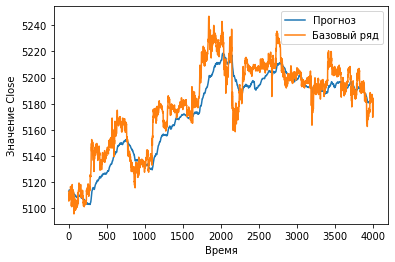

In [ ]:
#Отображаем график, что предсказала сеть и какие были правильные ответы
showPredict(0, 4000, 0, predVal, yValUnscaled)

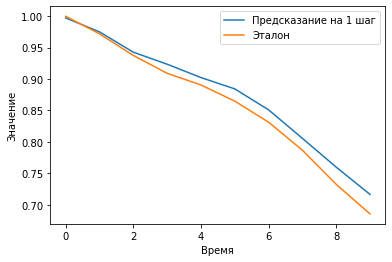

In [ ]:
#Отображаем корреляцию
showCorr([0], 10, predVal, yValUnscaled)

**Итог:** Созданная сложная сеть из LSTM и Conv1D слоёв на старте и Dense слоёв в конце, с предсказанием на один шаг и valLen = 30000, показала хороший результат. Корреляция на старте стремится к 99,9% и практически строго убывает, как и требовалось условием задачи.

## **ULTRA PRO**

**Задание:**

Найдите любую базу с временными рядами и напишите прогнозирование этого ряда на 10 шагов:
1. Спарсите, разделите и нормализуйте данные
2. Разделите данные на обучающую и проверочную выборки
3. Напишите сеть для прогнозирования временного ряда
4. Сделайте визуализацию результата
5. Напишите ваши результаты и выводы




In [ ]:
# Импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import utils #Для to_categorical
from tensorflow.keras.optimizers import Adam, Adadelta, RMSprop
from tensorflow.keras.models import Sequential, Model
from keras.models import load_model
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, SpatialDropout1D, BatchNormalization, MaxPooling1D, Flatten, Conv1D, LSTM, Activation
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator #Для генерации выборки временных рядов
from google.colab import files

%matplotlib inline

В качестве базы для этого задания была найдена и скачена в интернете база котировок Золота с 2009 по 2016 года.

In [ ]:
#Загружаем данные
base_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Базы/GOLD.csv', sep=',')

In [ ]:
base_data.head()

,<TICKER>,<PER>,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
0,SPFB.GOLD,1,20090111,103300,859.90002,859.90002,854.00000,854.00000,13
1,SPFB.GOLD,1,20090111,103700,854.40002,854.40002,854.40002,854.40002,2
2,SPFB.GOLD,1,20090111,103900,855.29999,855.29999,855.29999,855.29999,8
3,SPFB.GOLD,1,20090111,104700,856.29999,856.29999,856.29999,856.29999,1
4,SPFB.GOLD,1,20090111,105100,856.20001,856.20001,856.20001,856.20001,8


In [ ]:
base_data_gold = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Базы/GOLD.csv', sep=',')
gold_data = base_data_gold.iloc[:,4:]

In [ ]:
df = gold_data.copy()
data = np.array(df)  #Превращаем в numpy массив
df

,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
0,859.90002,859.90002,854.00000,854.00000,13
1,854.40002,854.40002,854.40002,854.40002,2
2,855.29999,855.29999,855.29999,855.29999,8
3,856.29999,856.29999,856.29999,856.29999,1
4,856.20001,856.20001,856.20001,856.20001,8
...,...,...,...,...,...
1048570,1144.80000,1145.10000,1144.80000,1145.10000,48
1048571,1145.10000,1145.10000,1145.10000,1145.10000,19
1048572,1145.20000,1145.30000,1145.00000,1145.00000,20
1048573,1144.80000,1144.80000,1144.70000,1144.80000,5


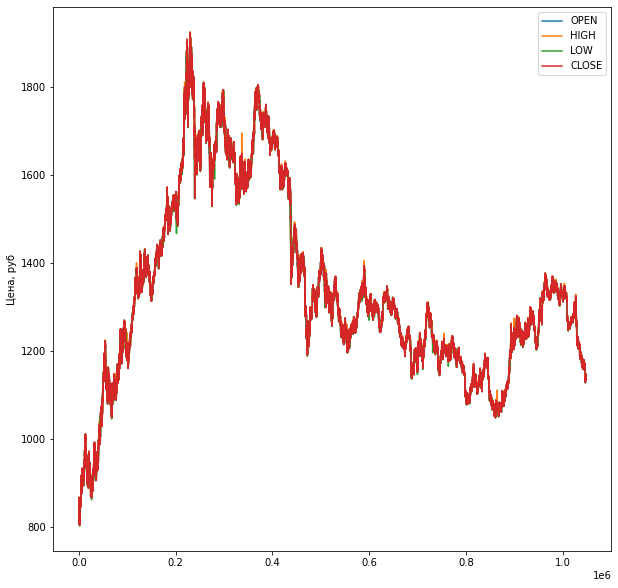

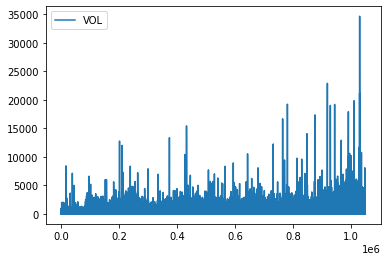

In [ ]:
# Отображаем исходные данные от точки srart и длиной step
start = 0 # С какой точки начинаем
step = data.shape[0] #С колько точек отрисуем

#Заполняем текстовые названия каналов данных
chanelNames = ['OPEN', 'HIGH', 'LOW', 'CLOSE', 'VOL']

#Рисуем все графики данных
#Четыре основных канала: 'OPEN', 'HIGH', 'LOW', 'CLOSE'

plt.figure(figsize=(10,10))
for i in range(4):
  plt.plot(data[start:start+step,i],
           label=chanelNames[i])
plt.ylabel('Цена, руб')
plt.legend()
plt.show()

#Канал 'VOL'
plt.plot(data[start:start+step,4], 
          label='VOL')
plt.legend()
plt.show()

In [ ]:
# Формируем параметры загрузки данных

xLen = 50                       # Анализируем по 50 прошедшим точкам 
valLen = 30000                  # Используем 30.000 записей для проверки

trainLen = data.shape[0]-valLen    # Размер тренировочной выборки

#Делим данные на тренировочную и тестовую выборки 
xTrain,xTest = data[:trainLen], data[trainLen+xLen+2:]

#Масштабируем данные (отдельно для X и Y), чтобы их легче было скормить сетке
xScaler = MinMaxScaler()
xScaler.fit(xTrain)
xTrain = xScaler.transform(xTrain)
xTest = xScaler.transform(xTest)

#Делаем reshape,т.к. у нас только один столбец по одному значению
yTrain,yTest = np.reshape(data[:trainLen,3],(-1,1)), np.reshape(data[trainLen+xLen+2:,3],(-1,1)) 
yScaler = MinMaxScaler()
yScaler.fit(yTrain)
yTrain = yScaler.transform(yTrain)
yTest = yScaler.transform(yTest)

#Создаем генератор для обучения
trainDataGen = TimeseriesGenerator(xTrain, yTrain,           #В качестве параметров наши выборки
                               length=xLen, sampling_rate=1, #Для каждой точки (из промежутка длины xLen)  stride=1,
                               batch_size=100)                #Размер batch, который будем скармливать модели

#Создаем аналогичный генератор для валидации при обучении
testDataGen = TimeseriesGenerator(xTest, yTest,
                               length=xLen, sampling_rate=1,
                               batch_size=100)

In [ ]:
print(trainDataGen[0][0].shape,
      trainDataGen[0][1].shape)

(20, 60, 5) (20, 1)


In [ ]:
# ************************************
# Функции для визуализации результатов
# ************************************

# Функция рассчета результата прогнозирования сети
#***
# В аргументы принимает сеть (currModel) и проверочную выборку
# Выдаёт результаты предсказания predVal
# И правильные ответы в исходной размерности yValUnscaled (какими они были до нормирования)
#***
def getPred(currModel, xVal, yVal, yScaler):
  # Предсказываем ответ сети по проверочной выборке
  # И возвращаем исходны масштаб данных, до нормализации
  predVal = yScaler.inverse_transform(currModel.predict(xVal))
  yValUnscaled = yScaler.inverse_transform(yVal)
  
  return (predVal, yValUnscaled)

# Функция отрисовывающая графики, что предсказала сеть и какие были правильные ответы
#***
# start - точка с которой начинаем отрисовку графика
# step - длина графика, которую отрисовываем
# channel - какой канал отрисовываем
#***
def showPredict(start, step, channel, predVal, yValUnscaled):
  plt.plot(predVal[start:start+step, 0],
           label='Прогноз')
  plt.plot(yValUnscaled[start:start+step, channel], 
           label='Базовый ряд')
  plt.xlabel('Время')
  plt.ylabel('Значение Close')
  plt.legend()
  plt.show()
  
# Функция расчёта корреляции дух одномерных векторов
def correlate(a, b):
  # Рассчитываем основные показатели
  ma = a.mean() # Среднее значение первого вектора
  mb = b.mean() # Среднее значение второго вектора
  mab = (a*b).mean() # Среднее значение произведения векторов
  sa = a.std() # Среднеквадратичное отклонение первого вектора
  sb = b.std() # Среднеквадратичное отклонение второго вектора
  
  #Рассчитываем корреляцию
  val = 1
  if ((sa>0) & (sb>0)):
    val = (mab-ma*mb)/(sa*sb)
  return val

# Функция отображающая на графике корреляцию прогнозированного сигнала с правильным
#***
# Смещая на различное количество шагов назад
# Для проверки появления эффекта автокорреляции
# channels - по каким каналам отображать корреляцию
# corrSteps - на какое количество шагов смещать сигнал назад для рассчёта корреляции
#***
def showCorr(channels, corrSteps, predVal, yValUnscaled):
  # Проходим по всем каналам
  for ch in channels:
    corr = [] # Создаём пустой лист, в нём будут корреляции при смезении на i рагов обратно
    yLen = yValUnscaled.shape[0] # Запоминаем размер проверочной выборки

      # Постепенно увеличикаем шаг, насколько смещаем сигнал для проверки автокорреляции
    for i in range(corrSteps):
      # Получаем сигнал, смещённый на i шагов назад
      # predVal[i:, ch]
      # Сравниваем его с верными ответами, без смещения назад
      # yValUnscaled[:yLen-i,ch]
      # Рассчитываем их корреляцию и добавляем в лист
      corr.append(correlate(yValUnscaled[:yLen-i,ch], predVal[i:, 0]))

    own_corr = [] # Создаём пустой лист, в нём будут корреляции при смещении на i шагов обратно

      # Постепенно увеличикаем шаг, насколько смещаем сигнал для проверки автокорреляции
    for i in range(corrSteps):
       own_corr.append(correlate(yValUnscaled[:yLen-i,ch], yValUnscaled[i:, ch]))

    # Отображаем график коррелций для данного шага
    plt.plot(corr, label='Предсказание на ' + str(ch+1) + ' шаг')
    plt.plot(own_corr, label='Эталон')

  plt.xlabel('Время')
  plt.ylabel('Значение')
  plt.legend()
  plt.show()

In [ ]:
# Создадим генератор проверочной выборки, из которой потом вытащим xVal, yVal для проверки
DataGen = TimeseriesGenerator(xTest, yTest,
                               length=xLen, sampling_rate=1,
                               batch_size=len(xTest)) # размер batch будет равен длине нашей выборки
xVal = []
yVal = []
for i in DataGen:
  xVal.append(i[0])
  yVal.append(i[1])

xVal = np.array(xVal)
yVal = np.array(yVal)

In [ ]:
yVal[0].shape

(29898, 1)

Epoch 1/100
10186/10186 [==============================] - 47s 5ms/step - loss: 3.1621e-04 - val_loss: 2.9480e-06
Epoch 2/100
10186/10186 [==============================] - 46s 5ms/step - loss: 5.8883e-05 - val_loss: 2.4905e-06
Epoch 3/100
10186/10186 [==============================] - 48s 5ms/step - loss: 3.4970e-05 - val_loss: 1.0803e-05
Epoch 4/100
10186/10186 [==============================] - 48s 5ms/step - loss: 2.5242e-05 - val_loss: 5.8385e-06
Epoch 5/100
10186/10186 [==============================] - 47s 5ms/step - loss: 3.1778e-05 - val_loss: 8.1107e-06
Epoch 6/100
10186/10186 [==============================] - 47s 5ms/step - loss: 1.7337e-05 - val_loss: 3.4412e-06
Epoch 7/100
10186/10186 [==============================] - 47s 5ms/step - loss: 1.7081e-05 - val_loss: 2.1786e-06
Epoch 8/100
10186/10186 [==============================] - 47s 5ms/step - loss: 1.6111e-05 - val_loss: 2.5581e-06
Epoch 9/100
10186/10186 [==============================] - 47s 5ms/step - loss: 1.7093e-

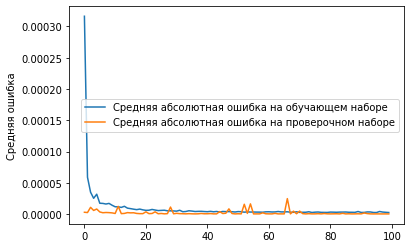

In [ ]:
# Создаем модель
modelD = Sequential()

modelD.add(Dense(200, input_shape = (xLen,5), activation="linear"))
modelD.add(Dense(200, activation="linear"))
modelD.add(Dense(200, activation="linear"))
modelD.add(Flatten())
modelD.add(Dense(1, activation="linear"))

# Компилируем
modelD.compile(loss="mse", optimizer=Adam(lr=1e-4))

# Обучаем
history = modelD.fit_generator(
                    trainDataGen, 
                    epochs=100, 
                    verbose=1, 
                    validation_data = testDataGen 
                    )

# Визуализируем результаты
plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [ ]:
# Прогнозируем данные текущей сетью
currModel = modelD
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], yScaler)

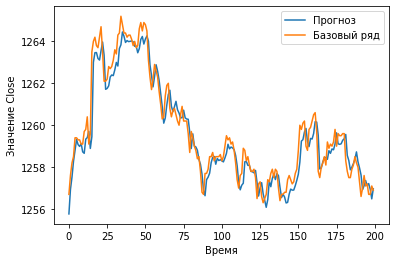

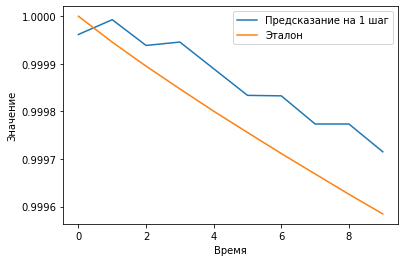

In [ ]:
#Отображаем график, что предсказала сеть и какие были правильные ответы
showPredict(10000, 200, 0, predVal, yValUnscaled)

# Отображаем корреляцию
showCorr([0], 10, predVal, yValUnscaled)

Учитывая, что маштаб очень маленький - нижняя граница = 0.9996, а вершняя = 1.0 (разница = 0.0004), то имеющиеся пики можно считать не значительными, тем более сам график идет строго убывает.

##### Прогнозирование на 10 шагов вперёд

In [ ]:
#Формируем параметры загрузки данных
xLen = 50                    #Анализируем по 50 прошедшим точкам 
valLen = 30000                  #Используем 30.000 записей для проверки
stepsForward = 10
trainLen = data.shape[0]-valLen #Размер тренировочной выборки

#Делим данные на тренировочную и тестовую выборки 
xTrain,xTest = data[:trainLen-stepsForward], data[trainLen+xLen+2:-stepsForward+1]

#Масштабируем данные (отдельно для X и Y), чтобы их легче было скормить сетке
xScaler = StandardScaler()
xScaler.fit(xTrain)
xTrain = xScaler.transform(xTrain)
xTest = xScaler.transform(xTest)

#Для подготовки yTrain на 10 шагов вперед необходимо создать дополнительный датасет
yTrain = np.array([data[:trainLen,0][i:i+stepsForward] for i in range(trainLen-stepsForward)])
yTest = np.array([data[trainLen+xLen+2:,0][i:i+stepsForward] for i in range(valLen-xLen-stepsForward-1)])
yScaler = StandardScaler()
yScaler.fit(yTrain)
yTrain = yScaler.transform(yTrain)
yTest = yScaler.transform(yTest)

#Создаем генератор для обучения
trainDataGen = TimeseriesGenerator(xTrain, yTrain,           #В качестве параметров наши выборки
                               length=xLen, sampling_rate=1, #Для каждой точки
                               batch_size=100)                #Размер batch, который будем скармливать модели

#Создаем аналогичный генератор для валидации при обучении
testDataGen = TimeseriesGenerator(xTest, yTest,
                               length=xLen, sampling_rate=1,
                               batch_size=100)

In [ ]:
print(trainDataGen[10][0].shape,
      trainDataGen[10][1].shape)

(100, 50, 5) (100, 10)


In [ ]:
#Создадим генератор проверочной выборки, из которой потом вытащим xVal, yVal для проверки
DataGen = TimeseriesGenerator(xTest, yTest,
                               length=xLen, sampling_rate=1,
                               batch_size=len(xTest)) #Размер batch будет равен длине нашей выборки

xVal = []
yVal = []
for i in DataGen:
  xVal.append(i[0])
  yVal.append(i[1])

xVal = np.array(xVal)
yVal = np.array(yVal)

Epoch 1/100
10186/10186 [==============================] - 40s 4ms/step - loss: 0.0024 - val_loss: 2.0053e-04
Epoch 2/100
10186/10186 [==============================] - 40s 4ms/step - loss: 8.4155e-04 - val_loss: 6.0027e-04
Epoch 3/100
10186/10186 [==============================] - 40s 4ms/step - loss: 9.4286e-04 - val_loss: 2.7429e-04
Epoch 4/100
10186/10186 [==============================] - 40s 4ms/step - loss: 4.4384e-04 - val_loss: 1.0269e-04
Epoch 5/100
10186/10186 [==============================] - 40s 4ms/step - loss: 4.7466e-04 - val_loss: 7.1750e-05
Epoch 6/100
10186/10186 [==============================] - 40s 4ms/step - loss: 3.2601e-04 - val_loss: 6.3179e-05
Epoch 7/100
10186/10186 [==============================] - 40s 4ms/step - loss: 3.2949e-04 - val_loss: 8.2752e-05
Epoch 8/100
10186/10186 [==============================] - 40s 4ms/step - loss: 3.5427e-04 - val_loss: 6.5195e-05
Epoch 9/100
10186/10186 [==============================] - 39s 4ms/step - loss: 3.1583e-04 -

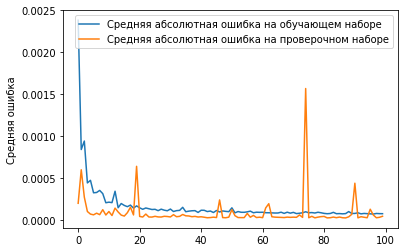

In [ ]:
# Создаем модель
modelD2 = Sequential()

modelD2.add(Dense(200, input_shape = (xLen,xTrain.shape[1]), activation="linear"))
modelD2.add(Dense(200, activation="linear"))
modelD2.add(Dense(200, activation="linear"))
modelD2.add(Flatten())
modelD2.add(Dense(yTrain.shape[1], activation="linear"))

# Компилируем
modelD2.compile(loss="mse", optimizer=Adam(lr=1e-4))

# Обучаем
history = modelD2.fit_generator(
                    trainDataGen, 
                    epochs=100, 
                    verbose=1, 
                    validation_data = testDataGen 
                    )

# Визуализируем результаты
plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

##### **Отображаем результаты** (10 графиков на разных отдельных осях)

In [ ]:
# Прогнозируем данные текущей сетью
currModel = modelD2
(predVal2, yValUnscaled2) = getPred(currModel, xVal[0], yVal[0], yScaler)

***************************************************
Прогнозирование на 1 шаг(а/ов) вперед:


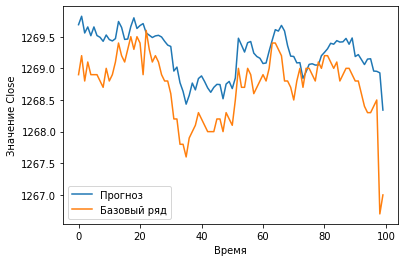

***************************************************
***************************************************
Прогнозирование на 2 шаг(а/ов) вперед:


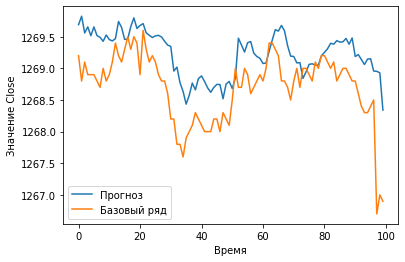

***************************************************
***************************************************
Прогнозирование на 3 шаг(а/ов) вперед:


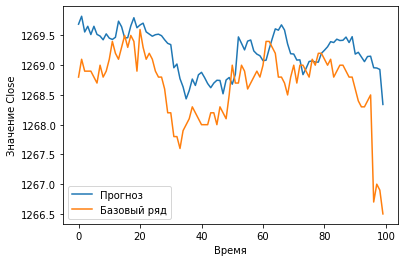

***************************************************
***************************************************
Прогнозирование на 4 шаг(а/ов) вперед:


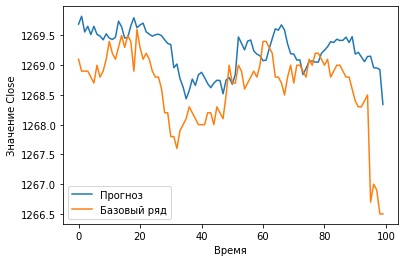

***************************************************
***************************************************
Прогнозирование на 5 шаг(а/ов) вперед:


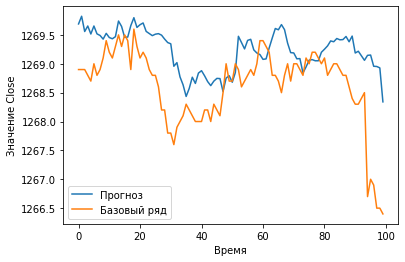

***************************************************
***************************************************
Прогнозирование на 6 шаг(а/ов) вперед:


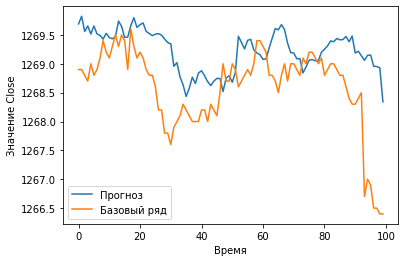

***************************************************
***************************************************
Прогнозирование на 7 шаг(а/ов) вперед:


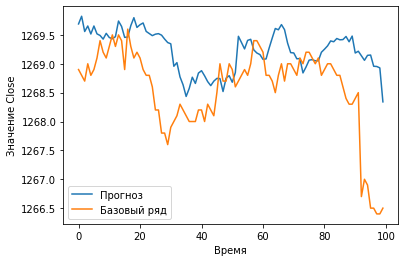

***************************************************
***************************************************
Прогнозирование на 8 шаг(а/ов) вперед:


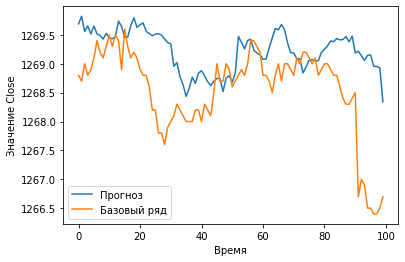

***************************************************
***************************************************
Прогнозирование на 9 шаг(а/ов) вперед:


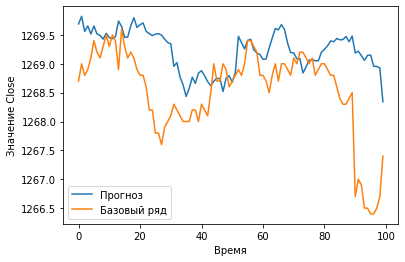

***************************************************
***************************************************
Прогнозирование на 10 шаг(а/ов) вперед:


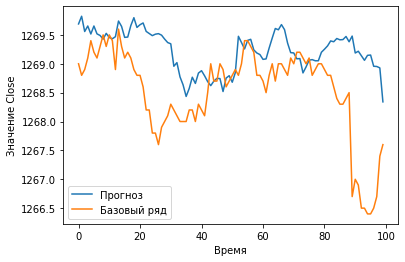

***************************************************


In [ ]:
# Построим графики сравнения предсказания с оригинальным сигналом
# по всем 10 шагам предсказания (10 графиков на разных отдельных осях).
for n in range(10):
  print("***************************************************")
  print("Прогнозирование на {} шаг(а/ов) вперед:".format(n+1))
  showPredict(0, 100, n, predVal2, yValUnscaled2)
  print("***************************************************")

***************************************************
Прогнозирование на 1 шаг(а/ов) вперед:


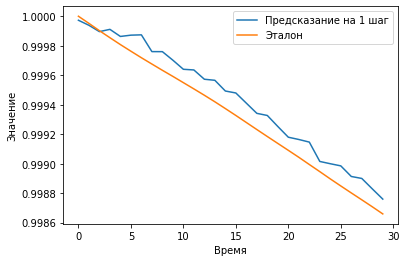

***************************************************
***************************************************
Прогнозирование на 2 шаг(а/ов) вперед:


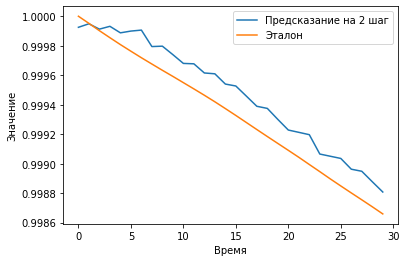

***************************************************
***************************************************
Прогнозирование на 3 шаг(а/ов) вперед:


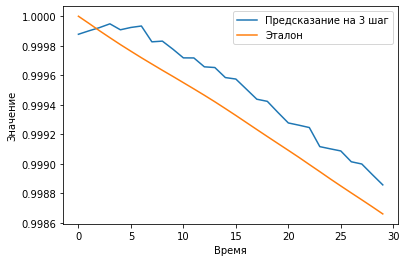

***************************************************
***************************************************
Прогнозирование на 4 шаг(а/ов) вперед:


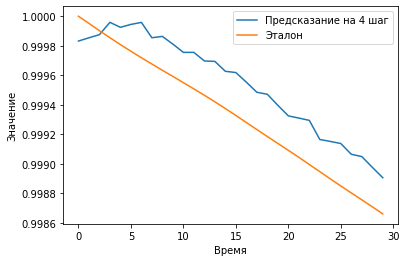

***************************************************
***************************************************
Прогнозирование на 5 шаг(а/ов) вперед:


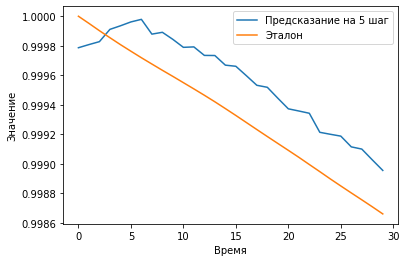

***************************************************
***************************************************
Прогнозирование на 6 шаг(а/ов) вперед:


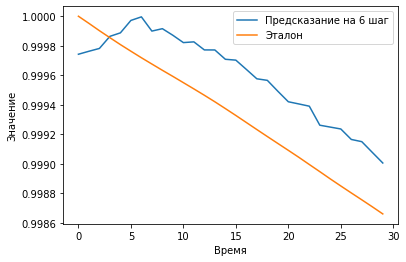

***************************************************
***************************************************
Прогнозирование на 7 шаг(а/ов) вперед:


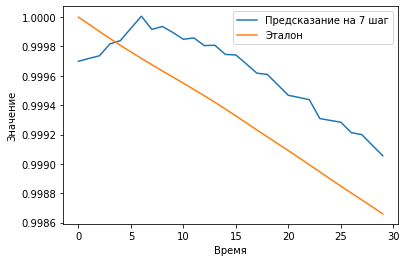

***************************************************
***************************************************
Прогнозирование на 8 шаг(а/ов) вперед:


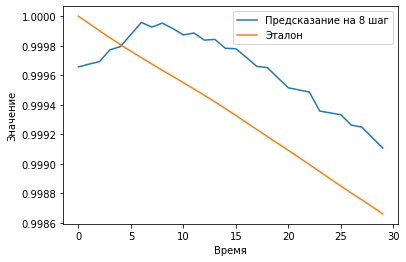

***************************************************
***************************************************
Прогнозирование на 9 шаг(а/ов) вперед:


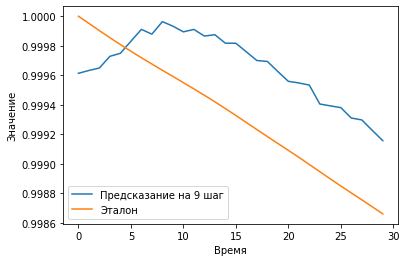

***************************************************
***************************************************
Прогнозирование на 10 шаг(а/ов) вперед:


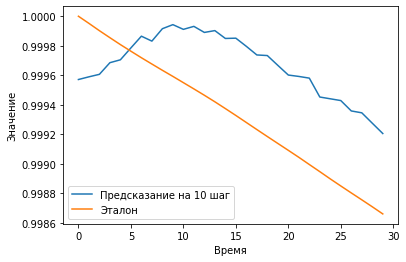

***************************************************


In [ ]:
#Отображаем корреляцию по всех 10 шагам
for n in range(10):
  print("***************************************************")
  print("Прогнозирование на {} шаг(а/ов) вперед:".format(n+1))
  showCorr([n, ], 30, predVal2, yValUnscaled2)
  print("***************************************************")

Учитывая, что маштаб очень маленький - нижняя граница = 0.9986, а вершняя = 1.0 (разница = 0.0014), то имеющиеся пики можно считать не значительными, тем более сам график корреляции убывает.
Итогом можно сказать что даже используя простую Dense сеть и встроенную функцию ошибки "mse", можно достичь неплохих результатов.